# LAB01 - Deteccion Pishing
### Integrantes
- Javier Valle
- Gabriel Vicente

### Librerias

In [36]:
import matplotlib.pyplot as plt
import tldextract
import pandas as pd
import math
import idna
import nltk
import re
import seaborn as sns
import numpy as np

from sklearn.metrics import precision_score, confusion_matrix, recall_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from urllib.parse import urlparse
from nltk.corpus import words
from sklearn import metrics


### Parte 1 – Ingeniería de características

### Exploración de datos

1. Cargue el dataset en un dataframe de pandas, muestre un ejemplo de cinco observaciones.

In [37]:
csv_path = './data/dataset_pishing.csv'
df = pd.read_csv(csv_path)

ejemplo_observaciones = df.head(5)
display(ejemplo_observaciones)


,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


2. Muestre la cantidad de observaciones etiquetadas en la columna status como “legit” y como
“pishing”. ¿Está balanceado el dataset?

Cantidad de observaciones etiquetadas como 'legit': 5715
Cantidad de observaciones etiquetadas como 'pishing': 5715


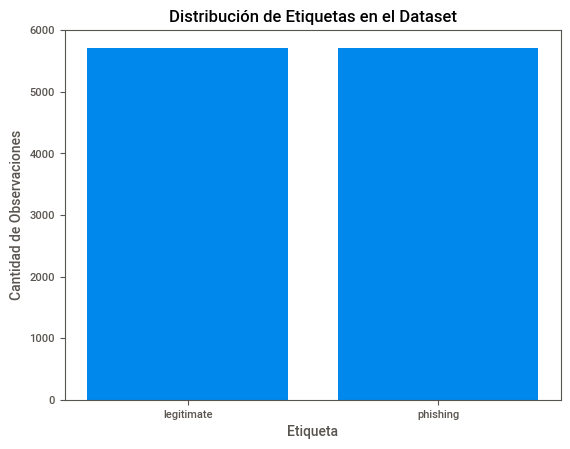

In [38]:
conteo_etiquetas = df['status'].value_counts()

print("Cantidad de observaciones etiquetadas como 'legit':", conteo_etiquetas['legitimate'])
print("Cantidad de observaciones etiquetadas como 'pishing':", conteo_etiquetas['phishing'])


plt.bar(conteo_etiquetas.index, conteo_etiquetas)
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Observaciones')
plt.title('Distribución de Etiquetas en el Dataset')

plt.show()

El dataset está perfectamente balanceado, dado que hay la misma cantidad de links legítimos y de phising.

### Derivación de características
En base a los artículos propuestos de clasificación de phishing, responda las siguientes preguntas:
1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo
de vida del dominio, o las características de la página Web?
2. ¿Qué características de una URL son más prometedoras para la detección de phishing?

En base a la respuesta anterior escriba al menos quince funciones basadas en los artículos, para
derivar características que un modelo pueda utilizar y añada dichas características al dataset original.

## Derivación de características.

1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, como el tiempo de vida del dominio, o las características de la página Web?

- La ventaja que tiene el análisis de una URL es que se analiza su string puro y con ello se puede saber si tiene caracteres especiales que podrían no existir en un link legítimo en caso de ser fraudulentos.

2. ¿Qué características de una URL son más prometedoras para la detección de phishing?

- Las características más prometedoras de un link son los números, @ y/o cualquier otro caracter especial. Otras características especiales pueden ser también la cantidad de veces que aparecen los números o caracteres especiales.


## Escribiendo al menos quince funciones basadas en los artículos.

Analizando la longitud del link.

In [39]:
def calculate_url_lengths(df):
    # Añade nuevas columnas al DataFrame para almacenar las longitudes
    df['full_url_length'] = df['url'].apply(len)
    df['hostname_length'] = df['url'].apply(lambda x: len(urlparse(x).hostname))

    return df


df = calculate_url_lengths(df)

print(df)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=0)

                                                     url      status   
0                  http://www.crestonwood.com/router.php  legitimate  \
1      http://shadetreetechnology.com/V4/validation/a...    phishing   
2      https://support-appleld.com.secureupdate.duila...    phishing   
3                                     http://rgipt.ac.in  legitimate   
4      http://www.iracing.com/tracks/gateway-motorspo...  legitimate   
...                                                  ...         ...   
11425      http://www.fontspace.com/category/blackletter  legitimate   
11426  http://www.budgetbots.com/server.php/Server%20...    phishing   
11427  https://www.facebook.com/Interactive-Televisio...  legitimate   
11428             http://www.mypublicdomainpictures.com/  legitimate   
11429  http://174.139.46.123/ap/signin?openid.pape.ma...    phishing   

       full_url_length  hostname_length  
0                   37               19  
1                   77               23  
2        

La función "calculate_url_lengths" se encarga de calcular y almacenar la longitud de las URLs completas y los nombres de los hosts de las URLs dentro del dataframe que se tiene dado. Esta característica es bastante útil para la detección del phishing, puesto que al momento de tener URLs anormalmente largos, la gran mayoría de veces contienen phishing cuando se entra en ellos.

Caracteres especiales

In [40]:
def count_special_characters(df):
    special_characters = ['.', '-', '@', '?', '&', '|', '=', '_', ' ̃', '%', '/', '*', ':', ',', ';', '$', '%20']

    for char in special_characters:
        col_name = f'f{special_characters.index(char) + 4}'  # Agregando 'f' para evitar errores en el nombre de la columna.
        df[col_name] = df['url'].apply(lambda x: x.count(char))

    return df


df = count_special_characters(df)

print(df)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

                                                     url      status   
0                  http://www.crestonwood.com/router.php  legitimate  \
1      http://shadetreetechnology.com/V4/validation/a...    phishing   
2      https://support-appleld.com.secureupdate.duila...    phishing   
3                                     http://rgipt.ac.in  legitimate   
4      http://www.iracing.com/tracks/gateway-motorspo...  legitimate   
...                                                  ...         ...   
11425      http://www.fontspace.com/category/blackletter  legitimate   
11426  http://www.budgetbots.com/server.php/Server%20...    phishing   
11427  https://www.facebook.com/Interactive-Televisio...  legitimate   
11428             http://www.mypublicdomainpictures.com/  legitimate   
11429  http://174.139.46.123/ap/signin?openid.pape.ma...    phishing   

       full_url_length  hostname_length  f4  f5  f6  f7  f8  f9  ...  f11   
0                   37               19   3   0   0   0   

La función "count_special_characters" tiene como finalidad contar la existencia de ciertos caracteres especiales en el contenido de las URLs del DataFrame que se proporcionó. En el caso de esta función se definió una lista de caractres "special_characters" que ayda a crear una nueva columna dentro del DataFrame y llena dicha columna con el número de veces que el caracter especial aparece en cada URL del DataFrame.

Calculando la proporción de dígitos en las URL's completas y en los hostnames.

In [41]:
def calculate_digit_ratio(df):
    df['full_url_digit_ratio'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    df['hostname_digit_ratio'] = df['url'].apply(lambda x: sum(c.isdigit() for c in urlparse(x).hostname) / len(urlparse(x).hostname) if urlparse(x).hostname else 0)

    return df

df = calculate_digit_ratio(df)

# Sobreescribiendo el archivo CSV con las nuevas columnas.
new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

La función "calculate_digit_ratio" se encarga de calcular y guardar la proporción de dígitso en las URLs completas y los nombres de los hosts de las URL en el DataFrame que se nos dio. Para ello, lo que se hizo fue calcular la proporción de caracteres de cada URL completa (que es el full_url_digit_ratio) y en el nombre del host (hostname_digit_ratio). Esta característica es bastante útil al momento de querer detectar algunos casos de phishing, dado que las URLs y los nombres de los hosts en algunas ocasiones cuentan con una alta proporción de dígitos son un indicativo bastante útil.

Detectando subdominios anormales 

In [42]:
def es_phishing(url):
    # Extrayendo el subdominio de la url
    subdominio = urlparse(url).hostname.split('.')[0]
    
    if re.match(r'w[w]?[0-9]*', subdominio):
        return 1
    else:
        return 0

df['abnormal_domain'] = df['url'].apply(es_phishing)

# Escribiendo un nuevo archivo CSV con las nuevas columnas.
new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

La función de "es_phishing" tiene como objetivo detectar si una URL tiene un potencial phishing en su subdominio. Para saber esta característica, se extrae el subdominio de la URL y luego la función verifica si el subdominio de la URL coincide con algún patrón específico. Si el subdominio coincide con este patrón, entonces la función devuelve un 1, indicando así que la URL es contenedora de un potencial phishing. En caso de que el subdominio de la URL no coincida, entonces la función devuelve un 0.

Dominios random

In [43]:
def calcular_entropia(s):
    frecuencia = [float(s.count(c)) / len(s) for c in dict.fromkeys(list(s))]
    
    entropia = -sum([p * math.log(p) / math.log(2.0) for p in frecuencia])
    
    return entropia

def random_domain(url):
    dominio = urlparse(url).hostname
    
    entropia = calcular_entropia(dominio)
    if entropia > 4:
        return 1
    else:
        return 0

df['random_domain'] = df['url'].apply(random_domain)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

La función "random_domain" se diseñó con el objetivo de que se detecte si cada URL del DataFrame pareciera ser aleatorio, puesto que dicha característica podría ser un buen indicador de phishing. Lo que primero se hace es extraer el dominio y luego se calcula la entropía usando así la función "calcular_entropía", la cual se encarga de calcular la incertidumbre de los caracteres dentro del dominio del URL. Con lo anterior, lo que se hace es que si la entropía es mayor a 4, entonces la función devuelve un 1, indicando así que el dominio pareciera ser aleatorio. Si en caso la entropía es menor a 4, entonces se devuelve un 0, entendiendo así que el dominio aparenta no ser aleatorio. 

Prefijos y sufijos

In [44]:
def prefix_suffix(url):
    # Extrayendo el dominio de la url
    dominio = urlparse(url).hostname
    
    # Comprobando si el dominio contiene "-"
    if '-' in dominio:
        return 1
    else:
        return 0

# Buscando los prefijos y sufijos en los dominios
df['prefix_suffix'] = df['url'].apply(prefix_suffix)


new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

La función de "prefix_suffix" se encarga de detectar que la URL contenga guiones, puesto que en algunos casos el phishing encontrado en las páginas se relaciona directamente con los guiones dentro de las URLs. Para saber si los links tienen guiones, lo que se hace es que se extrae el URL y se verifica que exista el "-" dentro del string del dominio. Si en caso el dominio tiene el "-", entonces se devuelve un 1, indicando así que la URL tiene phishing. Si en caso no hay guiones, entonces se devuelve un 0. 

Términos comunes

In [45]:
def common_terms(url):
    # Definiendo los términos comunes que quieres buscar
    terminos_comunes = ['www', '.com', 'http', '//']
    
    # Comprobando si todos los términos comunes están presentes en la url
    return int(all(termino in url for termino in terminos_comunes))

df['common_terms'] = df['url'].apply(common_terms)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

La función "common_terms" lo que hace es verificar si existen algunos términos comunes dentro del contenido de la URL. Para ello, lo que se hac es definir una lista de términos comunes y luego verifica que estos términos están presentes en cada URL del dataset. Si todos los términos están en la URL entonces se devuelve un 1, indicando que sí existen. Por otro lado, si estos no existieran en la URL entonces se devuelve un 0.

Puny code

In [46]:
def punycode(url):
    dominio = urlparse(url).hostname
    
    try:
        dominio_ascii = idna.encode(dominio).decode('utf-8')
    except idna.IDNAError:
        dominio_ascii = dominio
    
    if 'xn--' in dominio_ascii:
        return 1
    else:
        return 0

df['punycode'] = df['url'].apply(punycode)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

La función "punycode" se hace cargo de detectar si un dominio de URL usa propiamente Punycode, lo cual hace que se representen los caracteres Unicode con el conjunto restringido de caracteres ASCII permitidos dentro de los nombres de dominio de internet. Para detectar lo anterior mencionado, lo que se hace es extraer cada dominio de cada URL y luego se intenta codificar en ASCII usando idna. Si el dominio tiene el prefijo "xn-", lo cual es característico de Punycode, entonces se devuelve 1 lo cual indica que el dominio sí usa Punycode. Si no, se devuelve 0.

Contador de palabras

In [47]:
def word_count(url):
    palabras = re.split(r'\W+', url)
    return len(palabras)

df['word_count'] = df['url'].apply(word_count)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

El método de "word_count" se diseño con el fin de contar la cantidad de palabras en una URL. Esta función lo que hace es descomponer la URL en palabras, usando a si la función "re.split", lo que divide la URL en cada lugar donde encuentre un caracter que no sea alfanumérico. Luego, devuelve la cantidad de palabras resultantes y eso lo guarda en el DataFrame. 

Revisando si tiene caracteres especiales

In [48]:
def repeatead_characters(url):
    if re.search(r'(.)\1', url):
        return 1
    else:
        return 0

df['repeatead_characters'] = df['url'].apply(repeatead_characters)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

La función de "repeated_characters" se encarga de detectar si una URL contiene caracteres repetidos de manera consecutiva. Para detectar lo anterior mencionado, lo que se hace es usar una expresión regular con el fin de buscar cualquier caracter que se repita al menos una vez en la URL. Si encuentra caracteres repetidos, entonces la función devuelve un 1, indicando así que la URL sí tiene caracteres repetidos. En caso contrario, la función devuelve un 0. 

### Basado en el articulo <i>Quality Reliability Eng - 2023 - Calzarossa - Explainable machine learning for phishing feature detection</i>

tld_in_param

In [49]:
def tld_in_param(url):
    info_dominio = tldextract.extract(url)
    
    tiene_tld = bool(info_dominio.suffix)

    return 1 if tiene_tld else 0

df['TLD'] = df['url'].apply(tld_in_param)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)


La función "tld_in_param" busca detectar si una URL contiene un dominio de nivel superior. Para detectar ello, lo que hace es extraer información del dominio de la URL y luego verifica si tiene TLD. Si en caso el dominio contiene un TLD, entonces la función devuelve un 1, dando a entender que la URL sí tiene un TLD; en caso contrario se devuelve un 0.

length_param

In [50]:

def obtener_longitud_nombre_archivo(url):
    parsed_url = urlparse(url)
    
    path = parsed_url.path
    
    nombre_archivo = path.split("/")[-1]
    
    longitud_nombre_archivo = len(nombre_archivo)
    
    return longitud_nombre_archivo

df['length_param'] = df['url'].apply(obtener_longitud_nombre_archivo)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

email_in_url

In [51]:
def verificar_email_en_url(url):

    pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    match = re.search(pattern, url)

    if match:
        return 1
    else:
        return 0

df['email_in_url'] = df['url'].apply(verificar_email_en_url)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

dom_in_ip

In [52]:
def tiene_ip(url):
    patron_ip = r'\b(?:\d{1,3}\.){3}\d{1,3}\b'

    coincidencias = re.findall(patron_ip, url)

    return 1 if coincidencias else 0

df['dom_in_ip'] = df['url'].apply(tiene_ip)
new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

num_vowels_dom

In [53]:
def contar_vocales(url):
    url = url.lower()
    contador_vocales = sum(1 for letra in url if letra in 'aeiou')

    return contador_vocales

df['num_vowels_dom'] = df['url'].apply(contar_vocales)
new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

Preprocesamiento de los datos

In [54]:

mapeo = {'legitimate': 0, 'phishing': 1}

df['status'] = df['status'].replace(mapeo)

display(df)
if 'url' in df.columns:
    df.drop(columns=['url'], inplace=True)
else:
    pass


new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

,url,status,full_url_length,hostname_length,f4,f5,f6,f7,f8,f9,...,prefix_suffix,common_terms,punycode,word_count,repeatead_characters,TLD,length_param,email_in_url,dom_in_ip,num_vowels_dom
0,http://www.crestonwood.com/router.php,0,37,19,3,0,0,0,0,0,...,0,1,0,6,1,1,10,0,0,8
1,http://shadetreetechnology.com/V4/validation/a...,1,77,23,1,0,0,0,0,0,...,0,0,0,6,1,1,32,0,0,24
2,https://support-appleld.com.secureupdate.duila...,1,126,50,4,1,0,1,2,0,...,1,0,0,15,1,1,0,0,0,30
3,http://rgipt.ac.in,0,18,11,2,0,0,0,0,0,...,0,0,0,4,1,1,0,0,0,3
4,http://www.iracing.com/tracks/gateway-motorspo...,0,55,15,2,2,0,0,0,0,...,0,1,0,9,1,1,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,45,17,2,0,0,0,0,0,...,0,1,0,6,1,1,11,0,0,10
11426,http://www.budgetbots.com/server.php/Server%20...,1,84,18,5,0,1,1,0,0,...,0,1,0,14,1,1,9,1,0,22
11427,https://www.facebook.com/Interactive-Televisio...,0,105,16,2,6,0,1,0,0,...,0,1,0,14,1,1,0,0,0,25
11428,http://www.mypublicdomainpictures.com/,0,38,30,2,0,0,0,0,0,...,0,1,0,5,1,1,0,0,0,9


Escalando algunas columnas

In [55]:
from sklearn.preprocessing import StandardScaler

columnas_a_escalar = ['full_url_length', 'hostname_length', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'full_url_digit_ratio', 'hostname_digit_ratio', 'word_count', 'length_param', 'num_vowels_dom']

scaler = StandardScaler()

df[columnas_a_escalar] = scaler.fit_transform(df[columnas_a_escalar])

df.to_csv('./data/dataset_preprocesado.csv', index=False)


Visualización de resultados

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:04 -> (00:00 left)



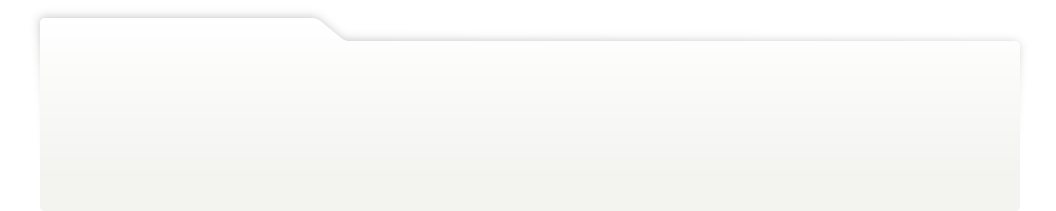
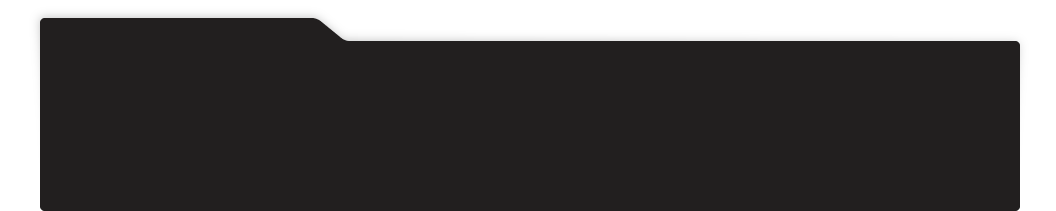
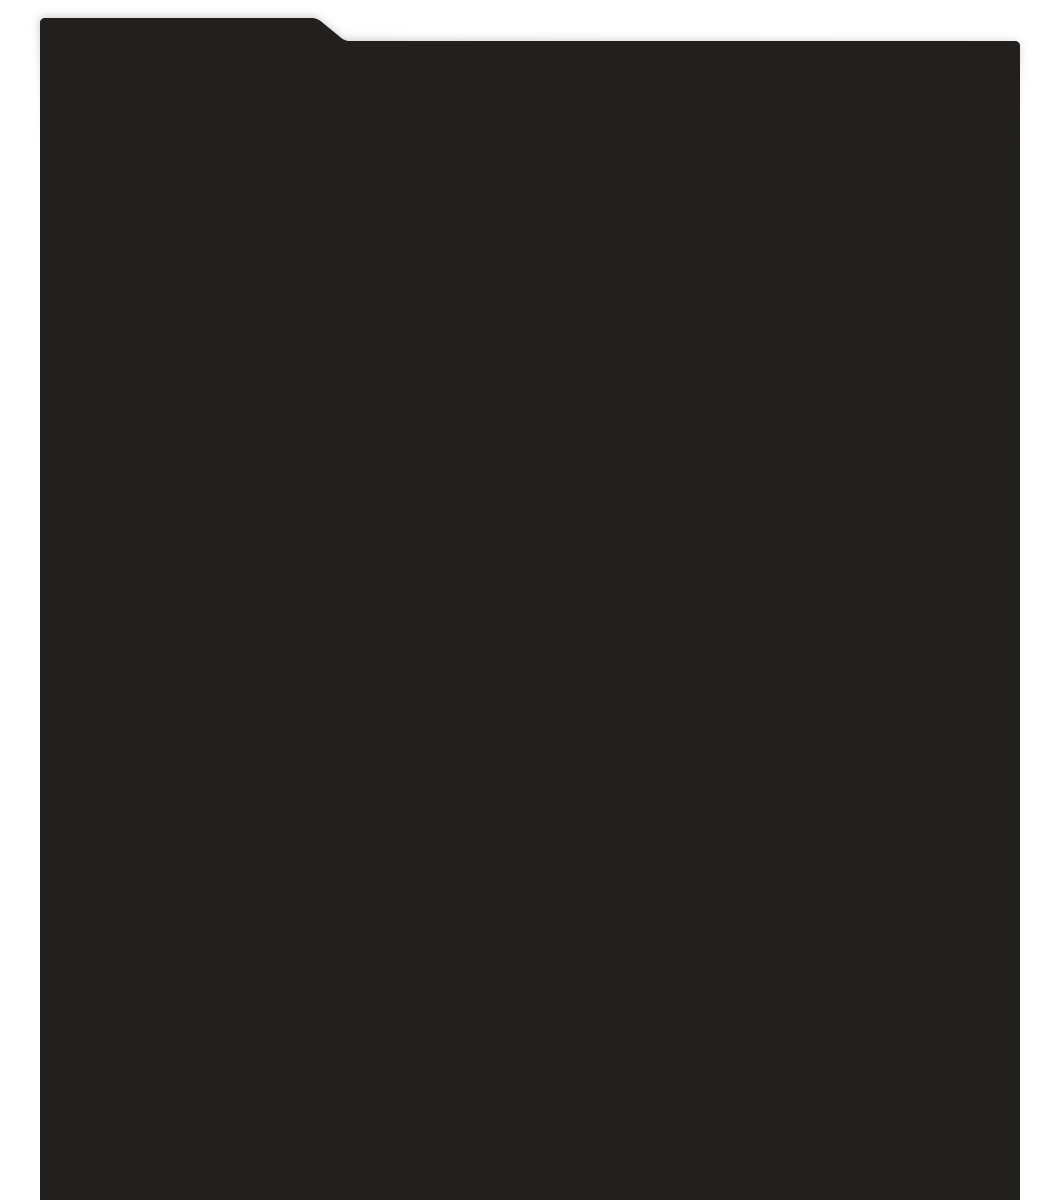
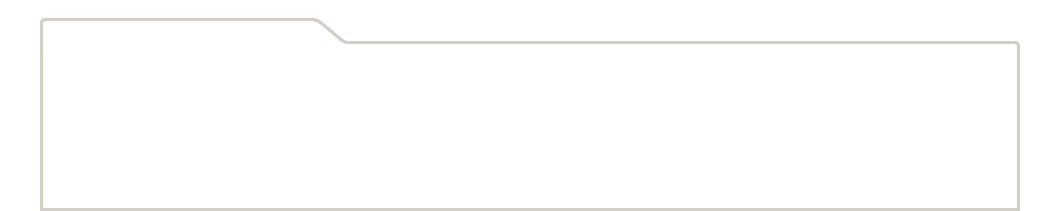
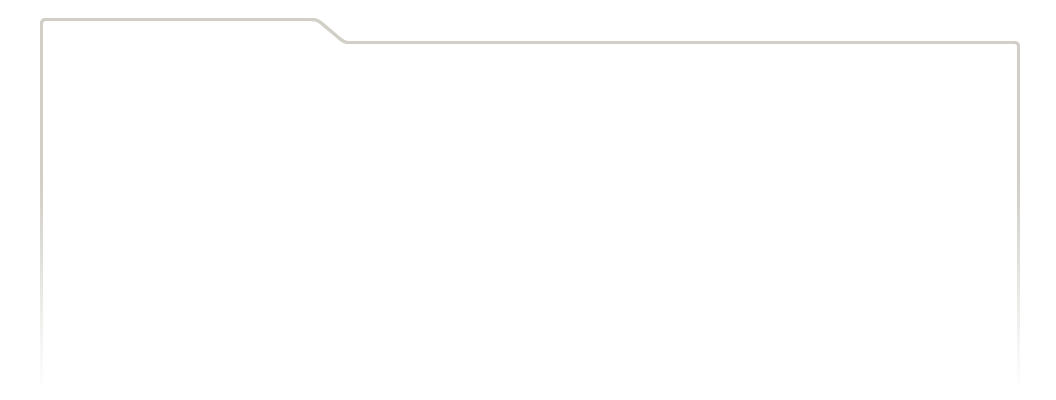
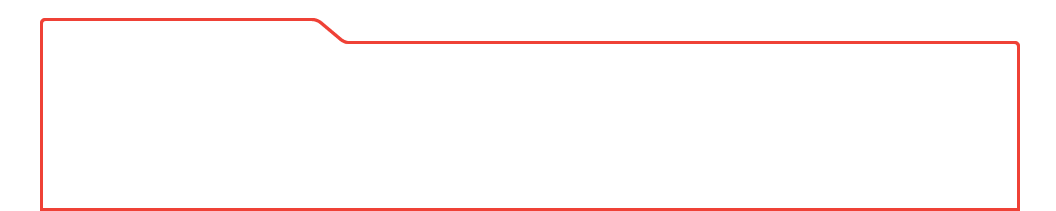
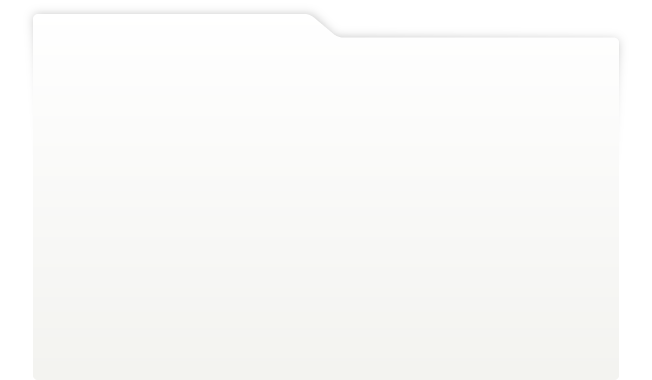
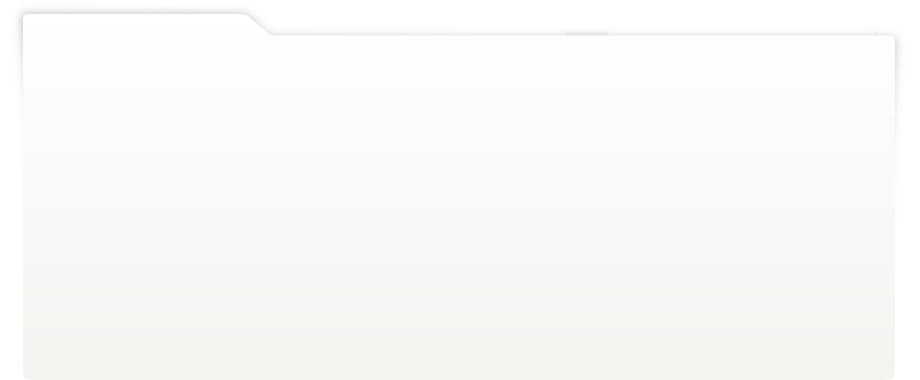
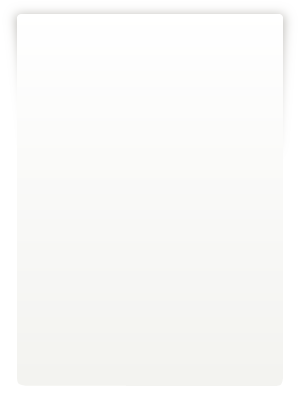
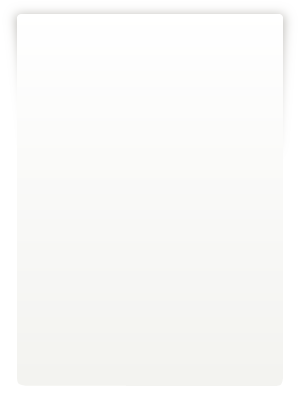
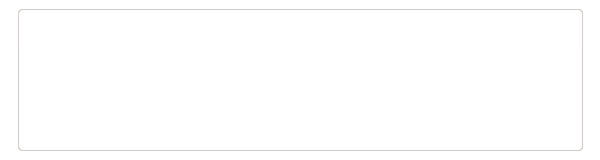
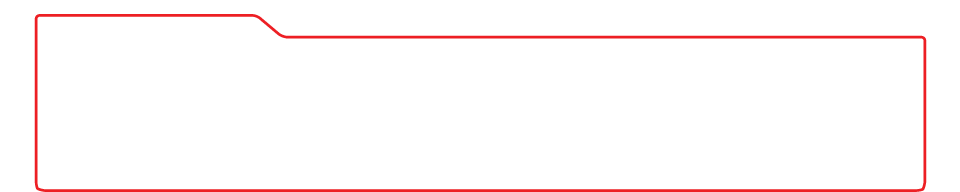
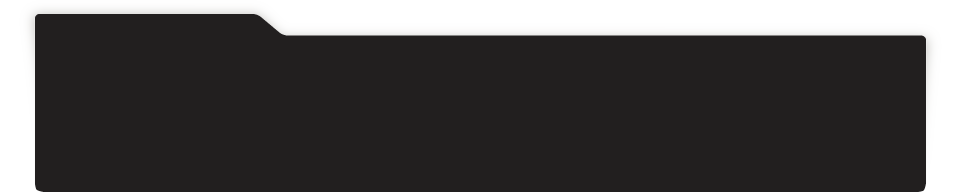
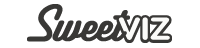
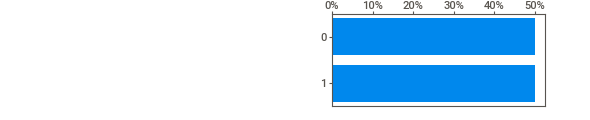
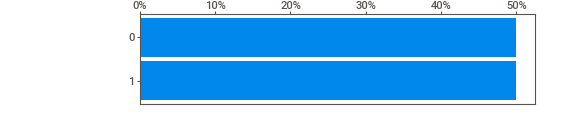
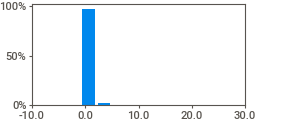
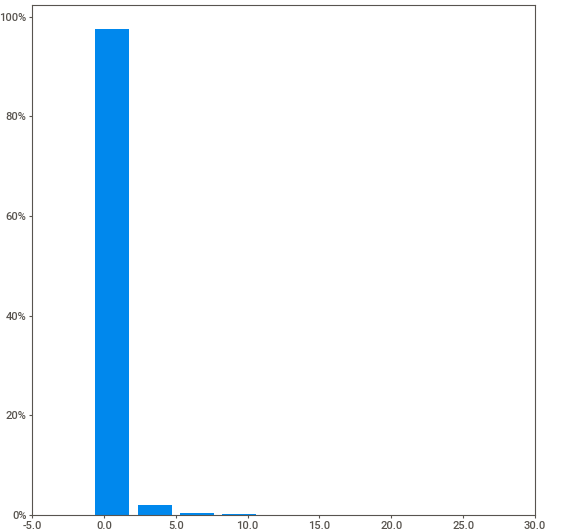
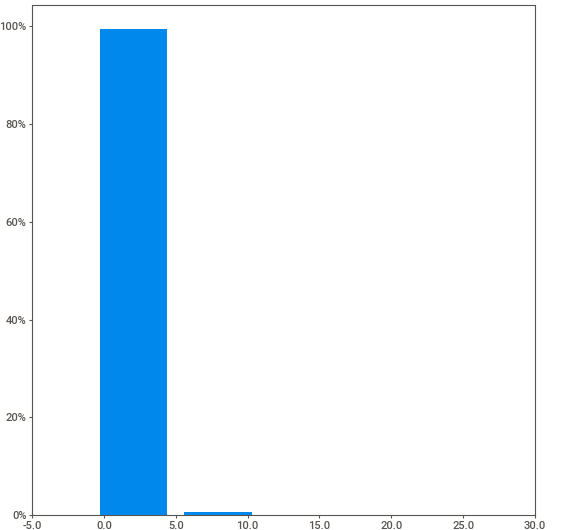
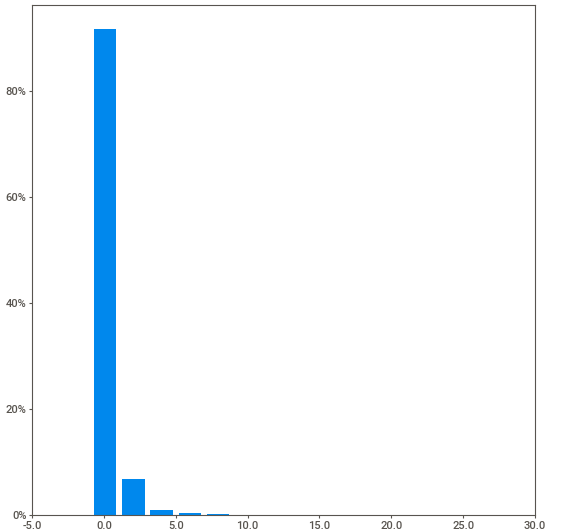
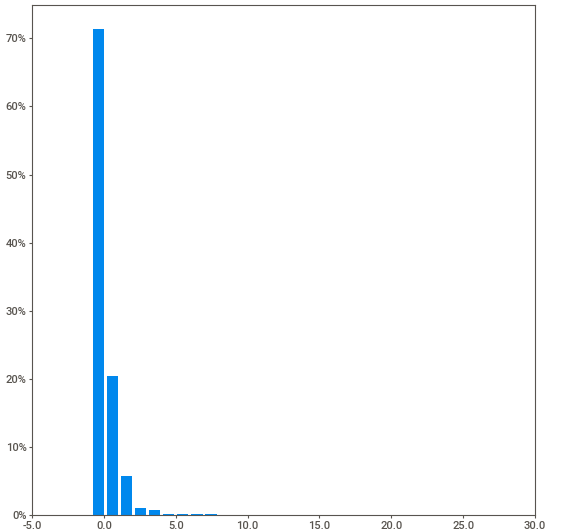
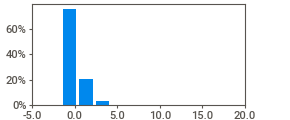
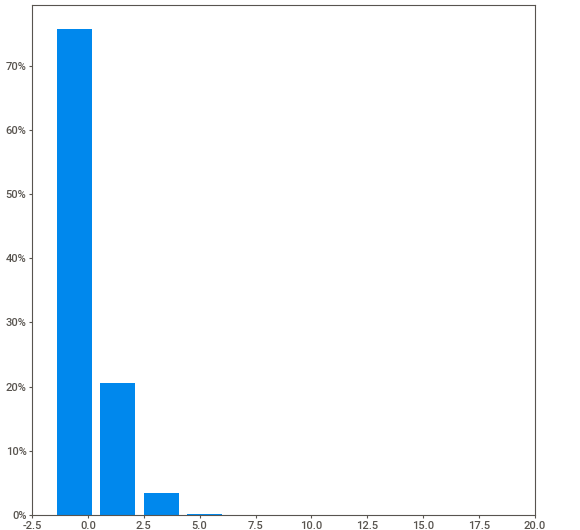
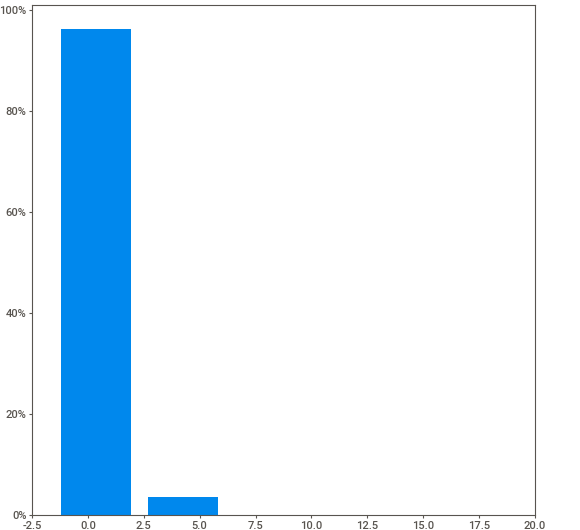
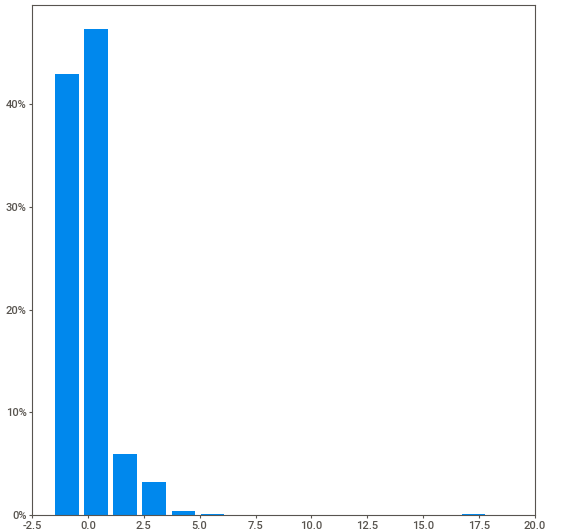
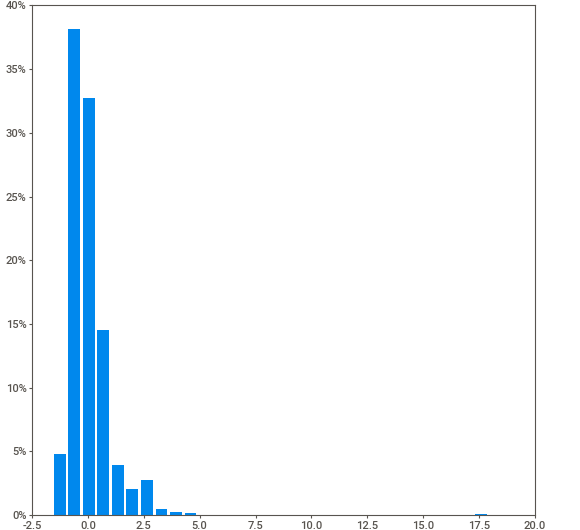
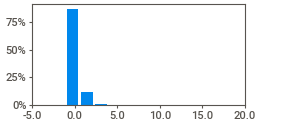
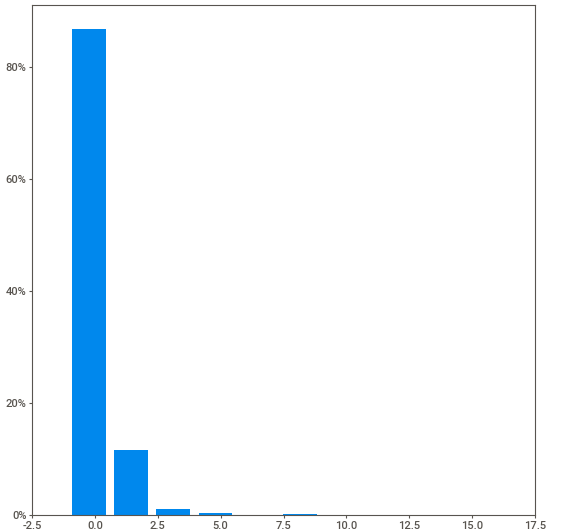
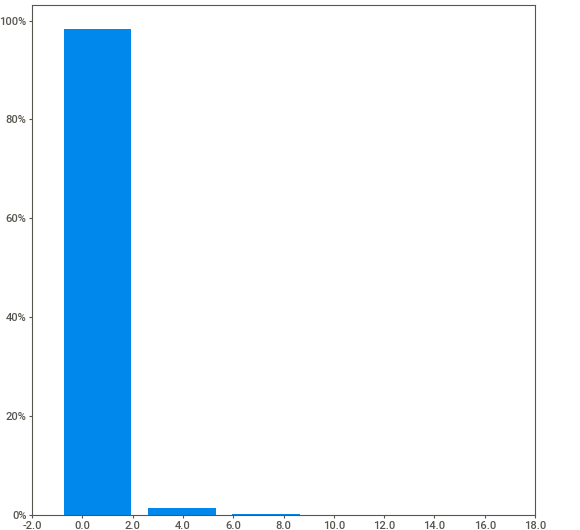
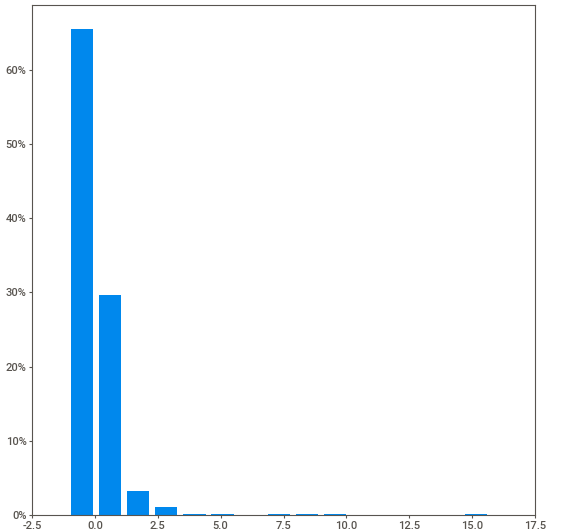
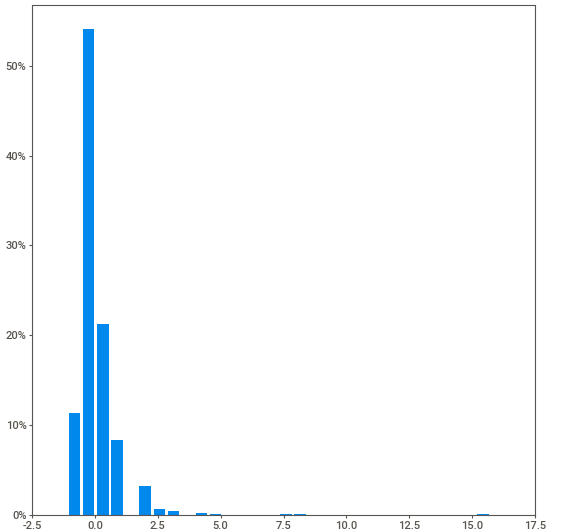
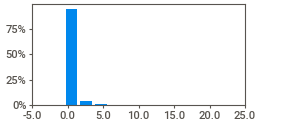
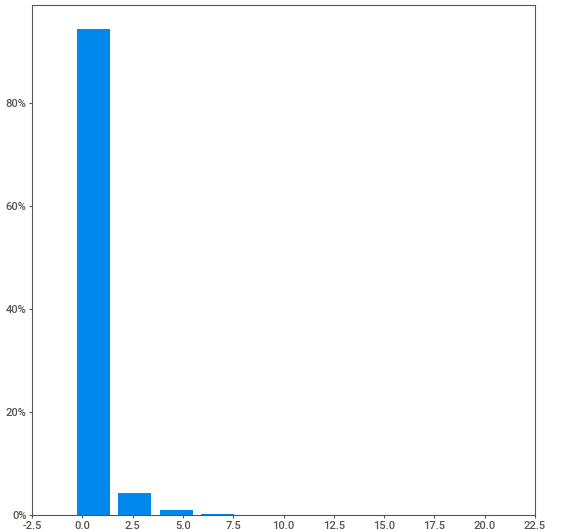
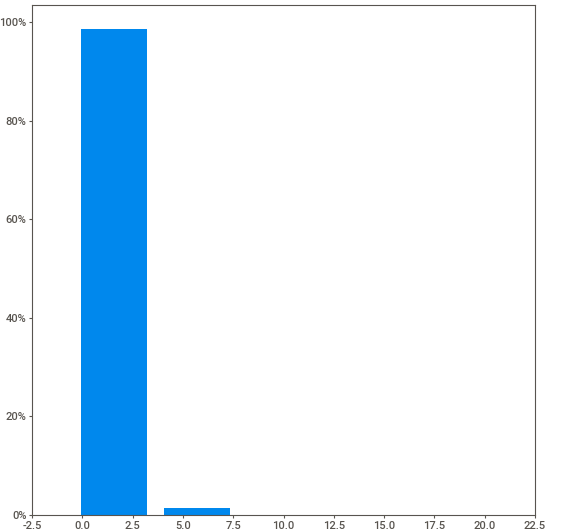
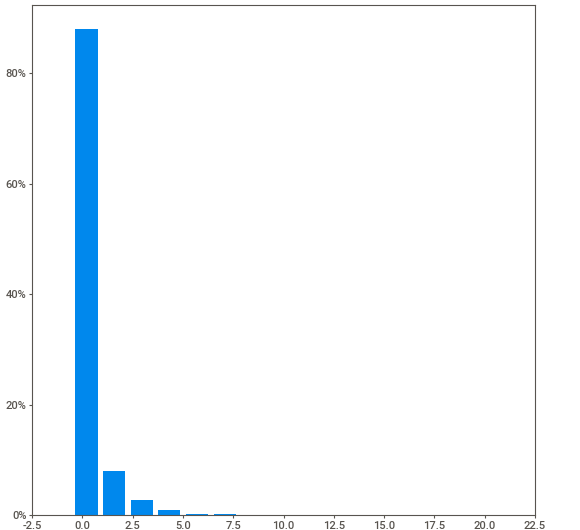
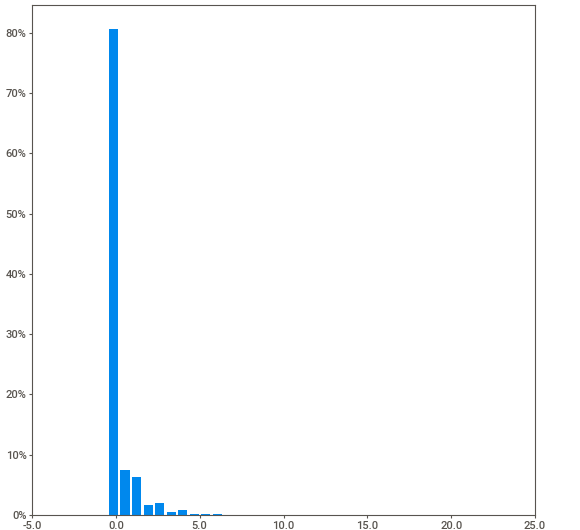
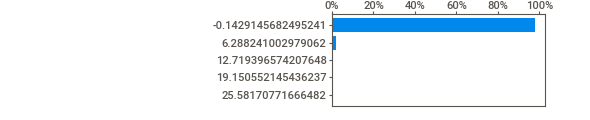
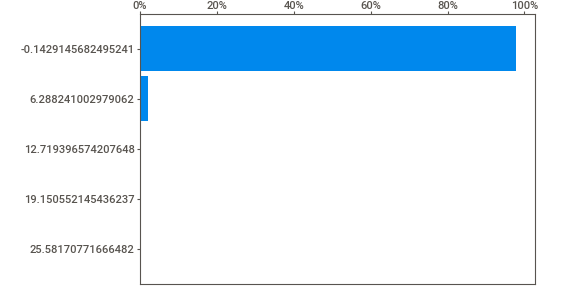
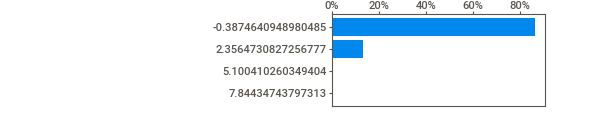
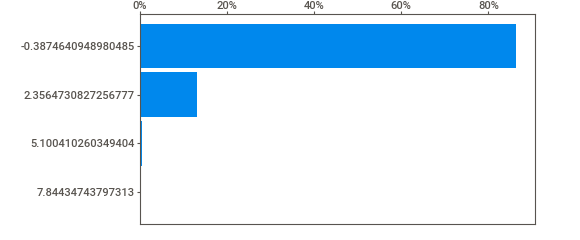
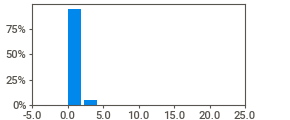
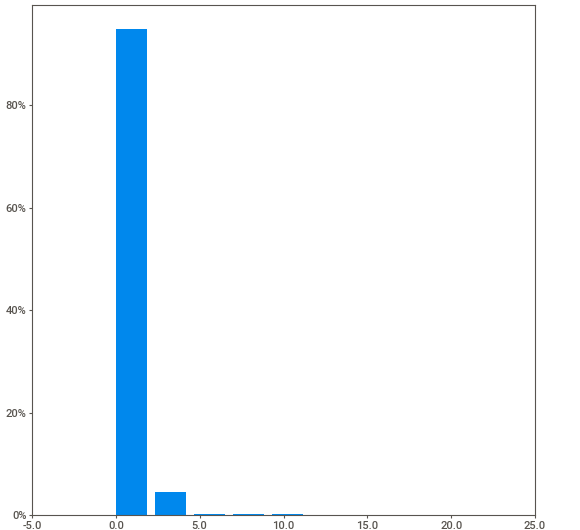
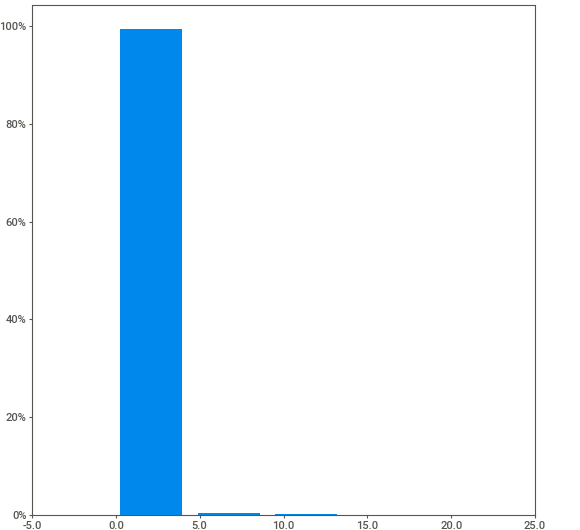
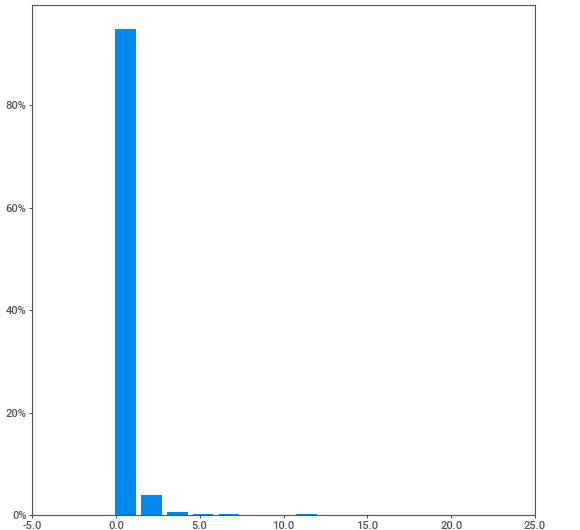
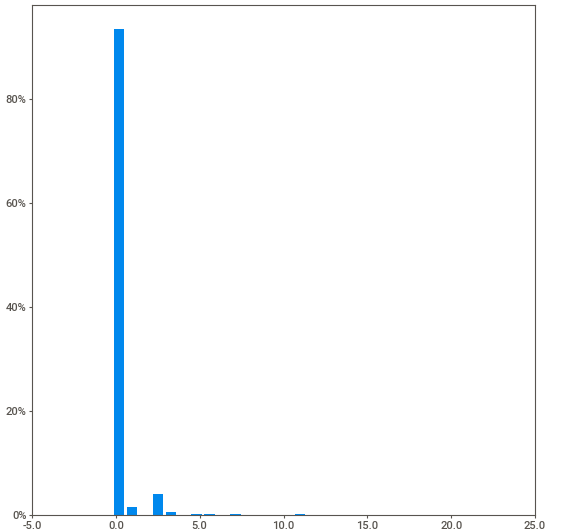
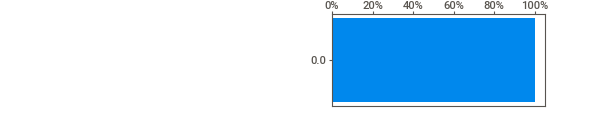
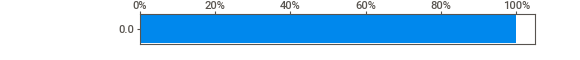
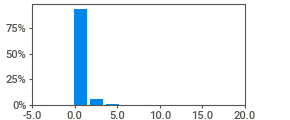
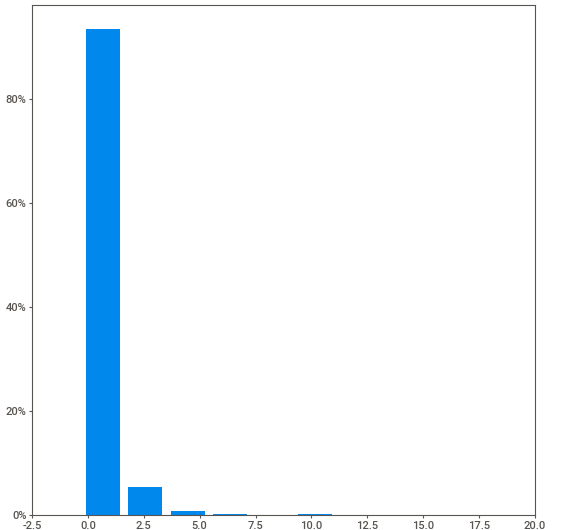
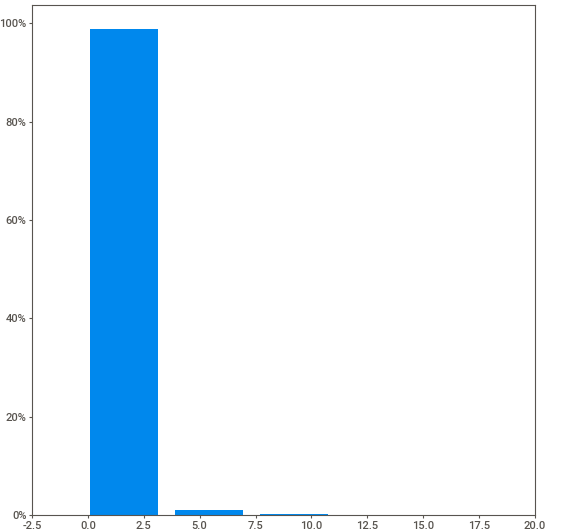
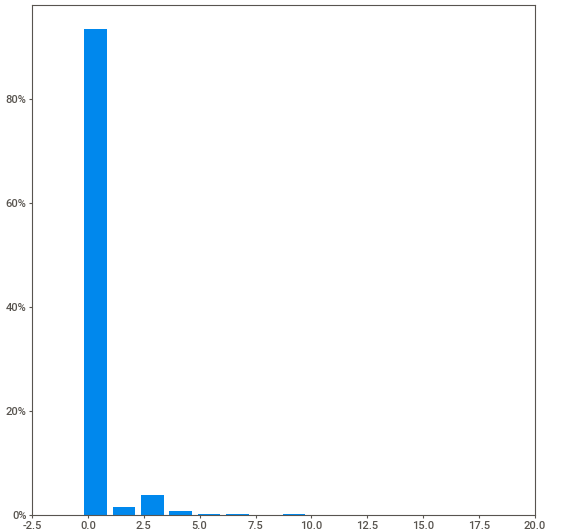
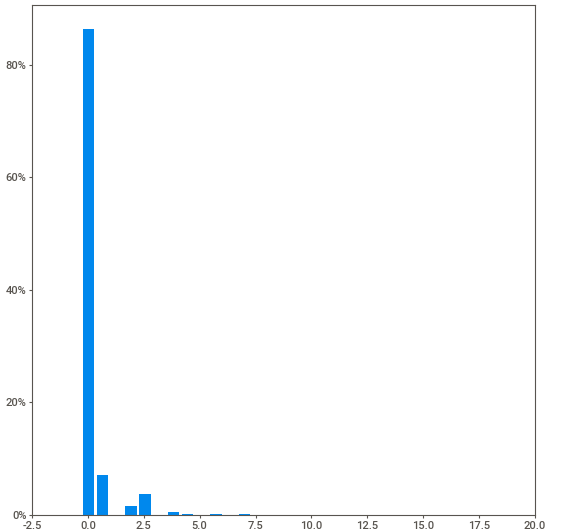
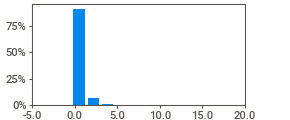
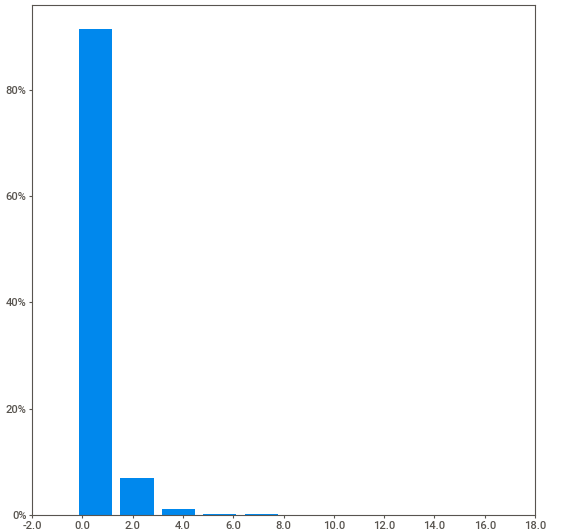
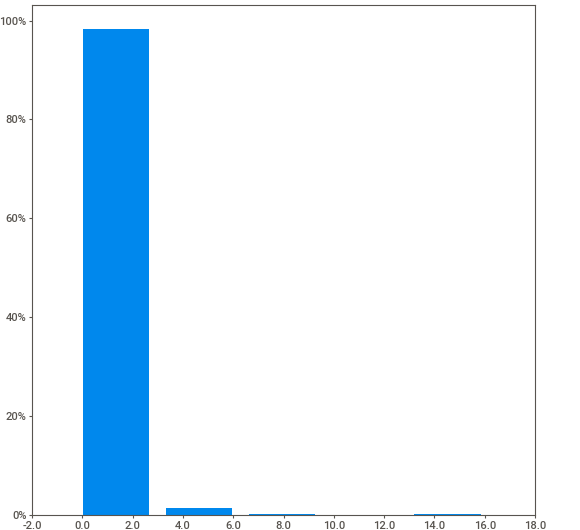
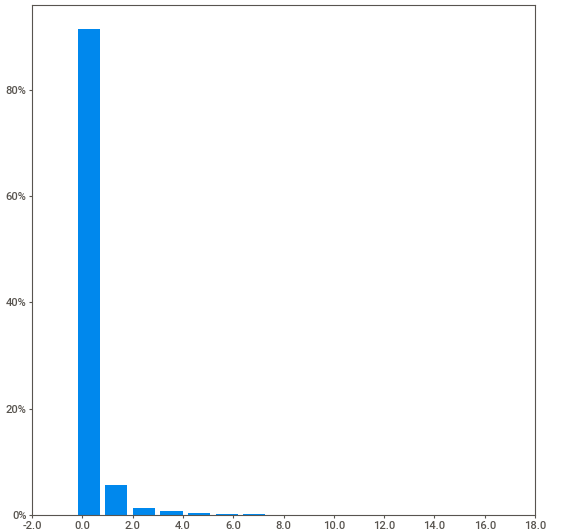
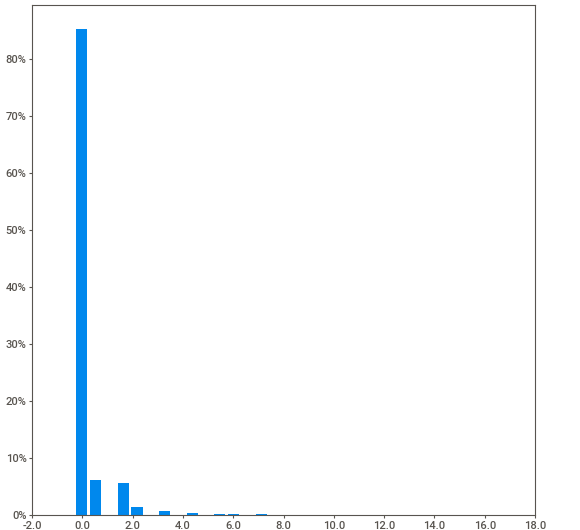
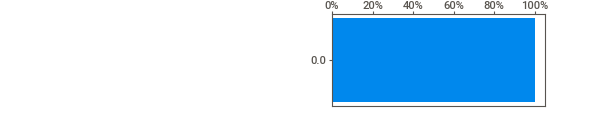
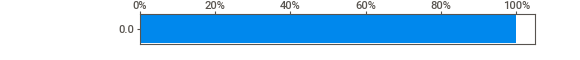
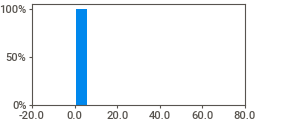
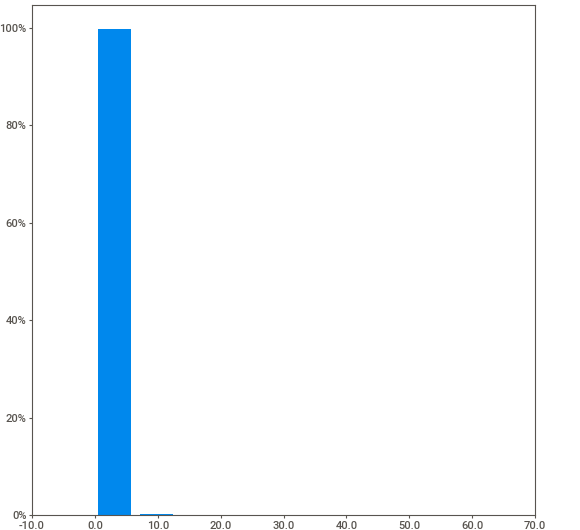
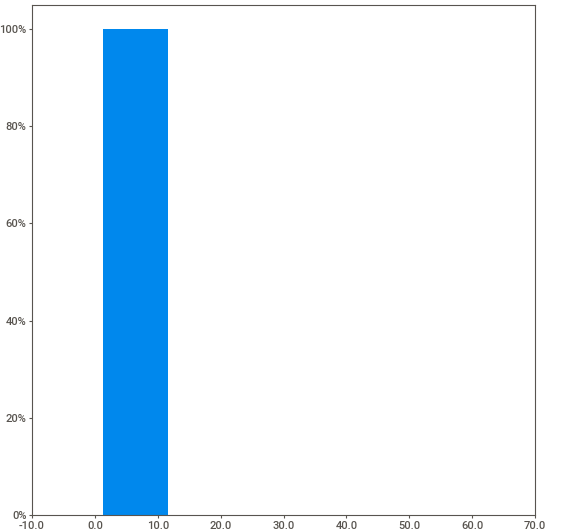
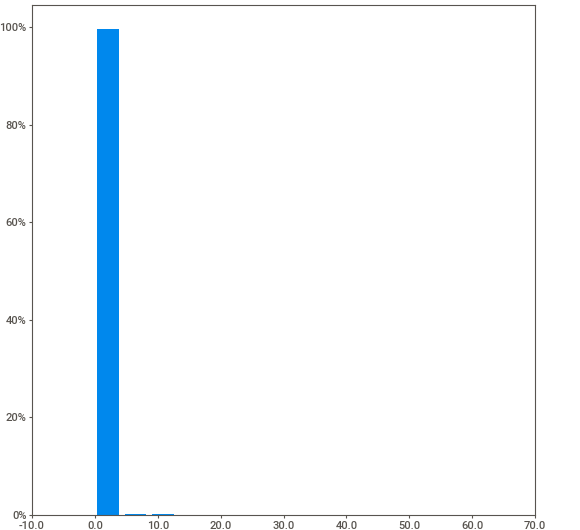
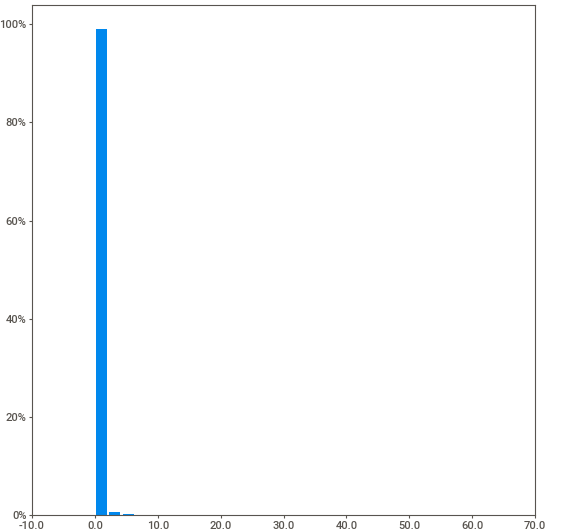
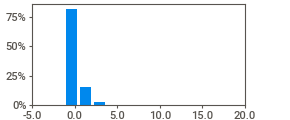
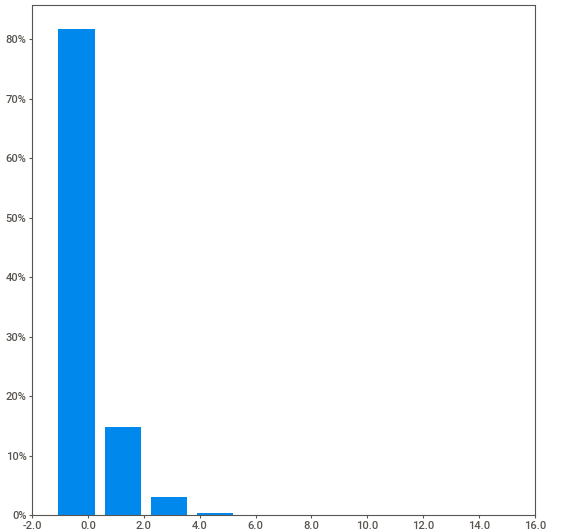
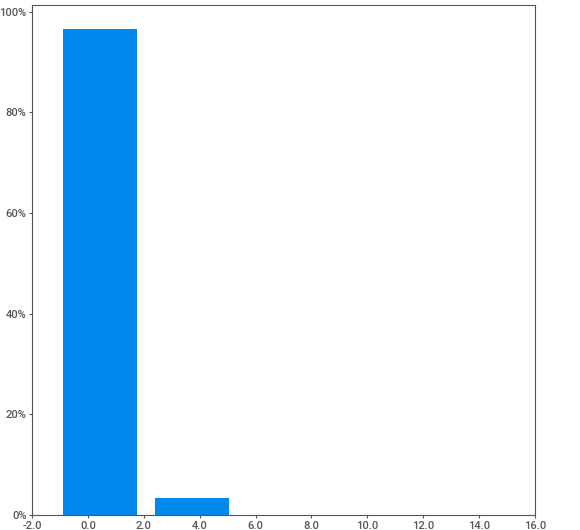
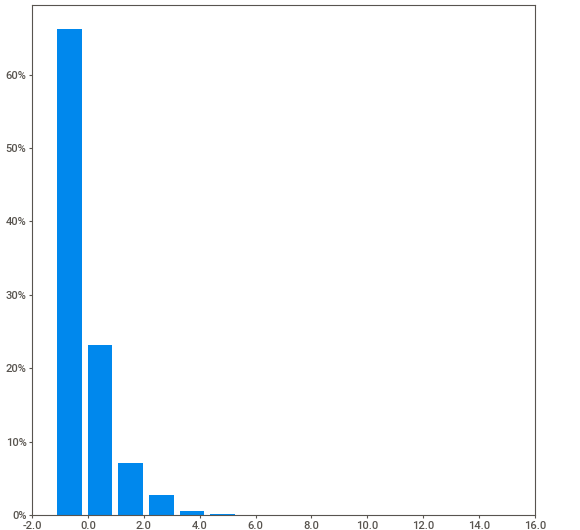
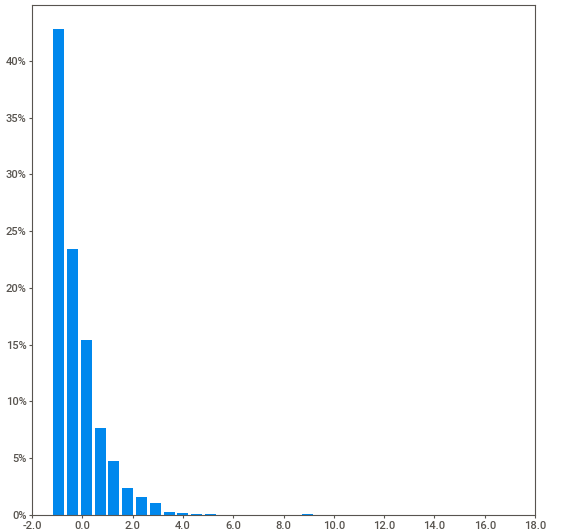
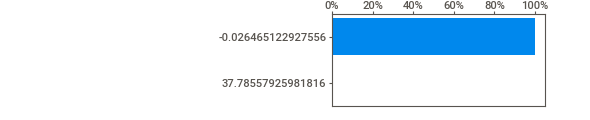
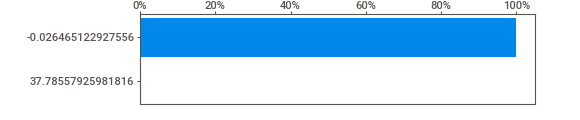
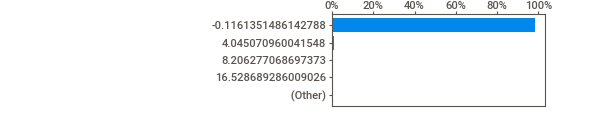
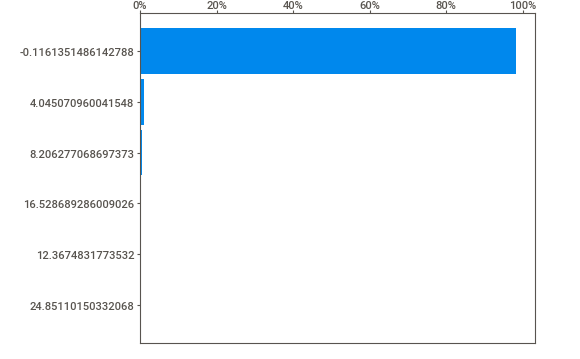
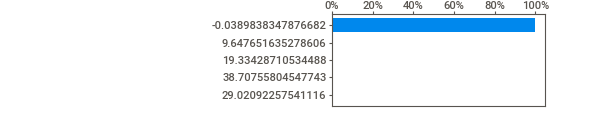
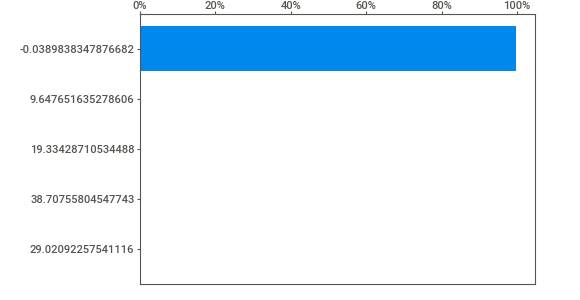
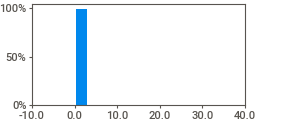
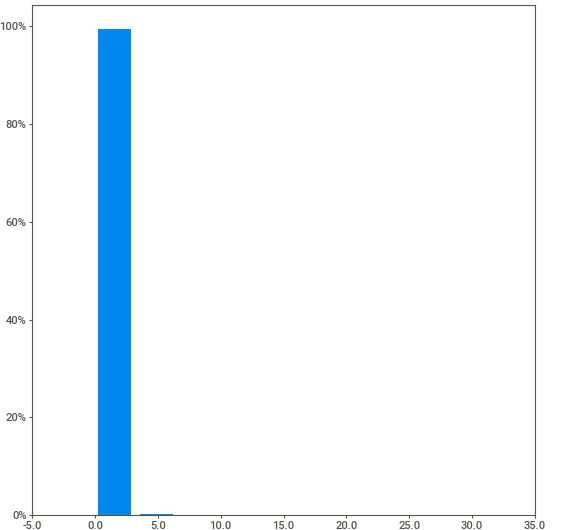
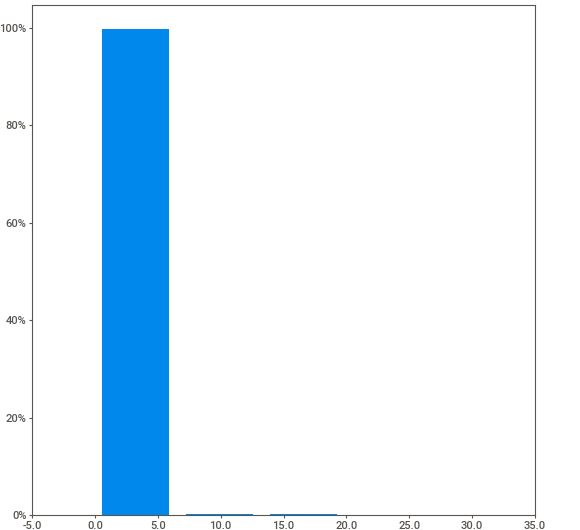
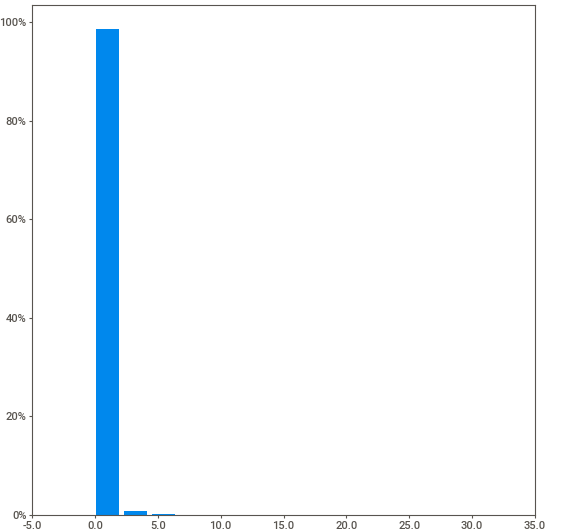
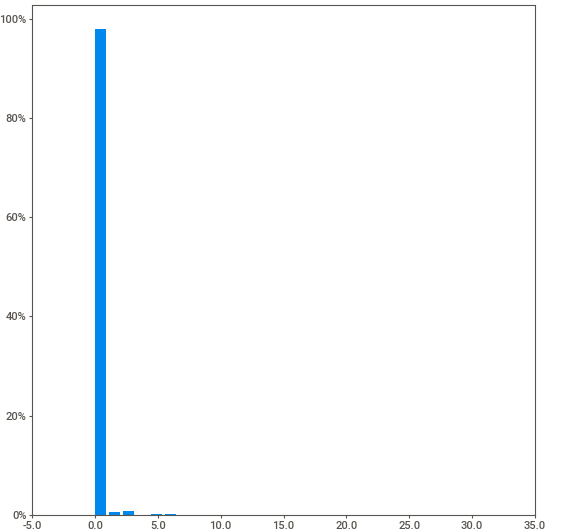
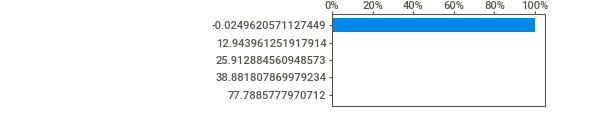
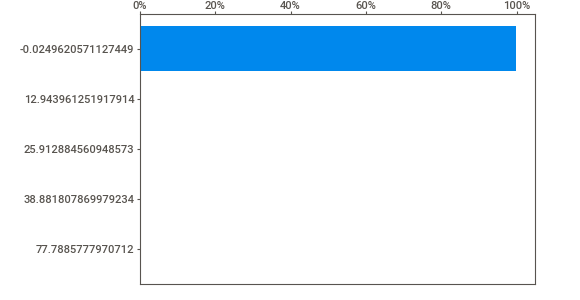
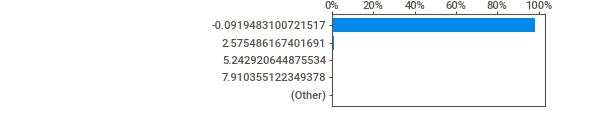
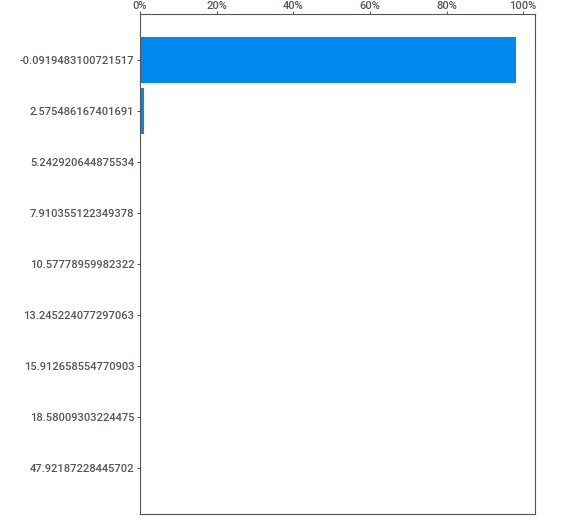
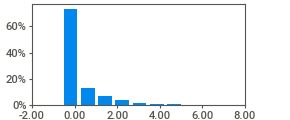
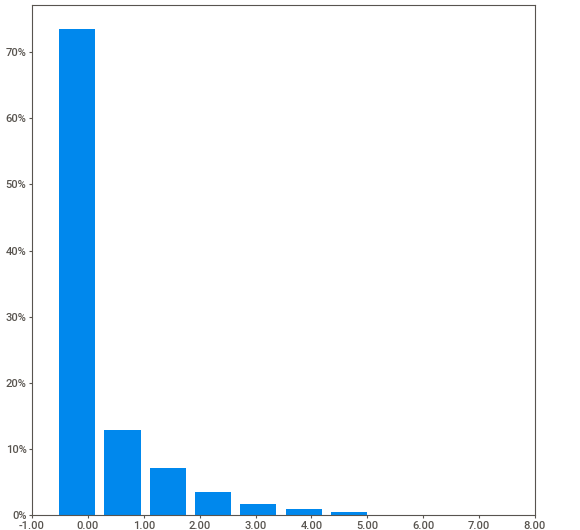
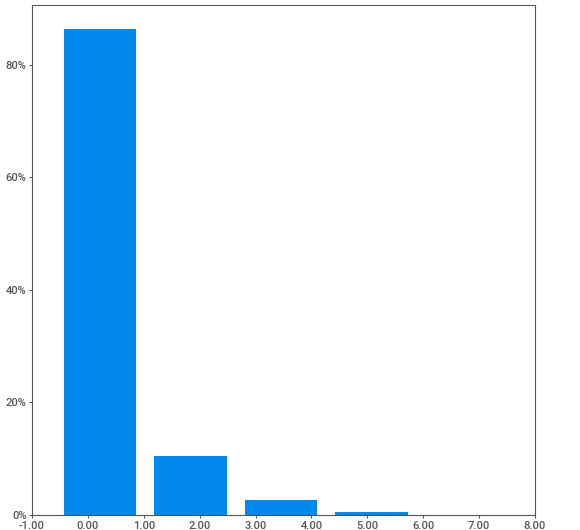
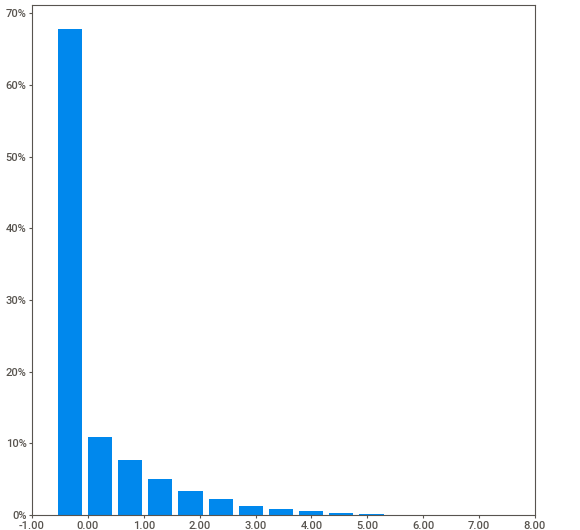
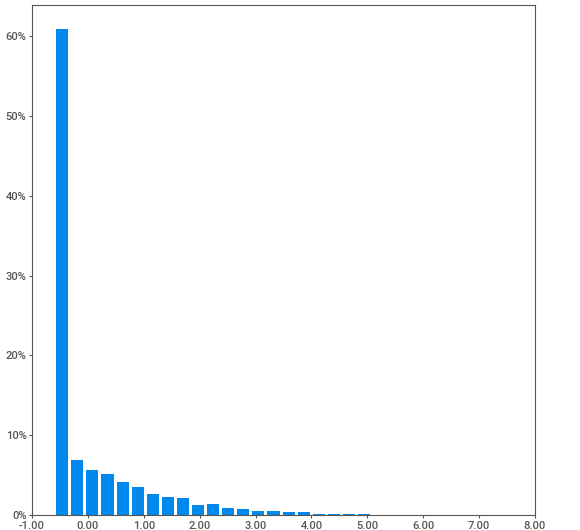
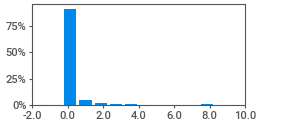
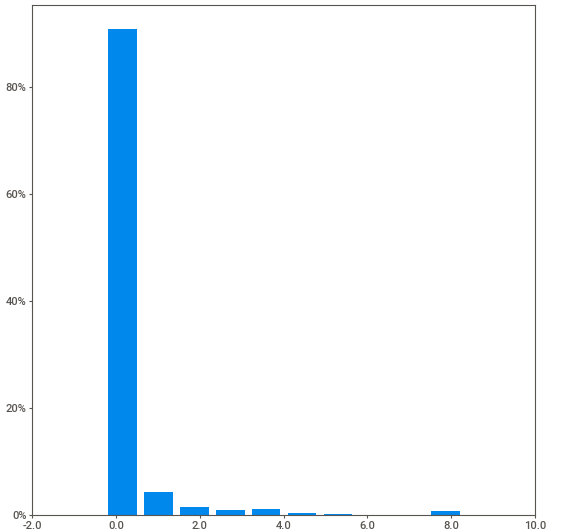
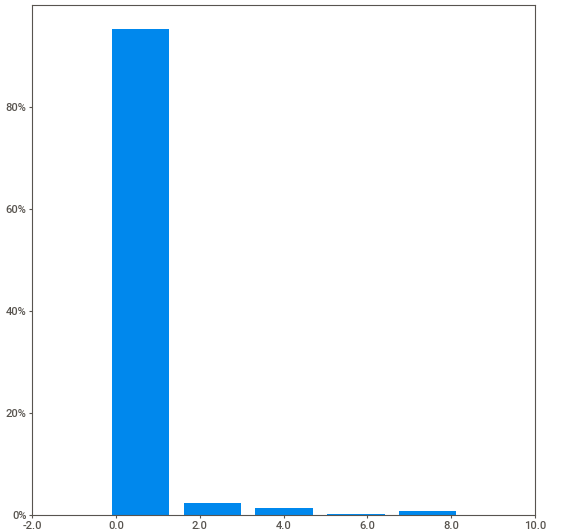
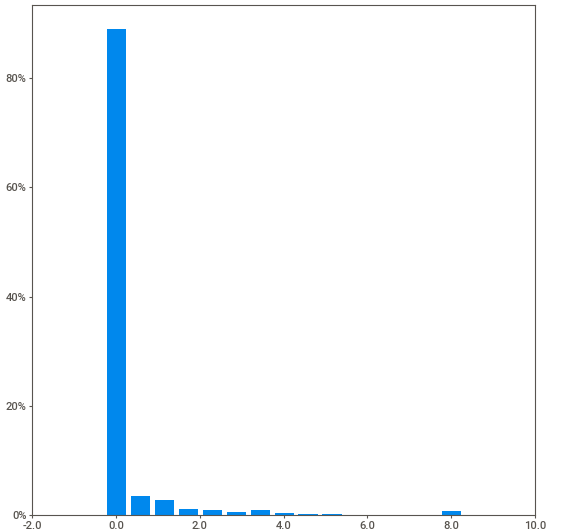
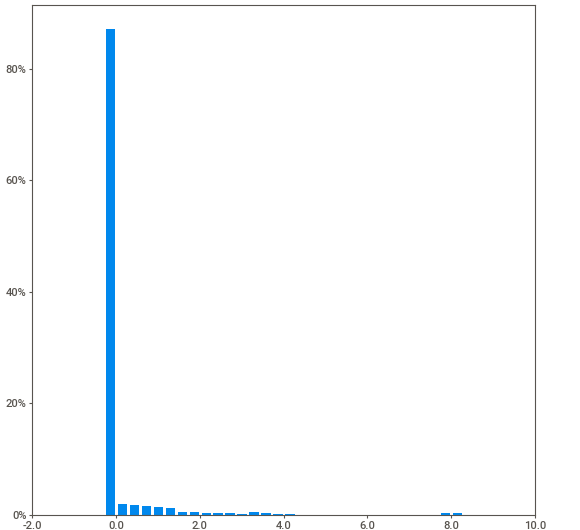
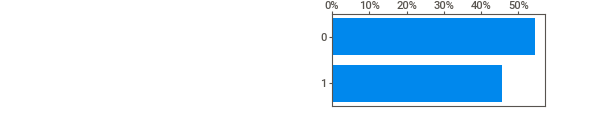
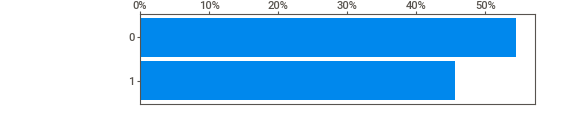
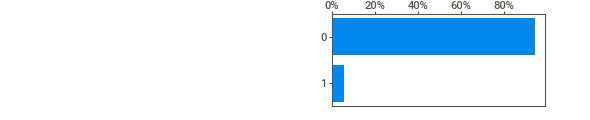
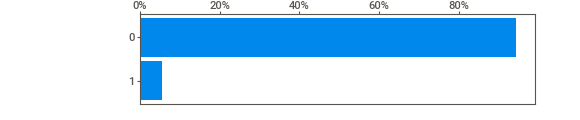
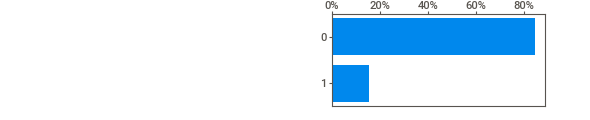
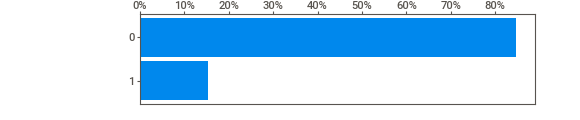
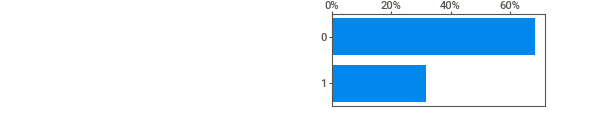
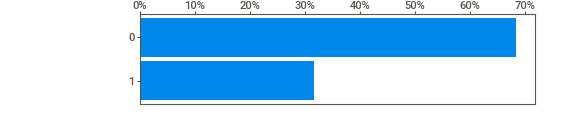
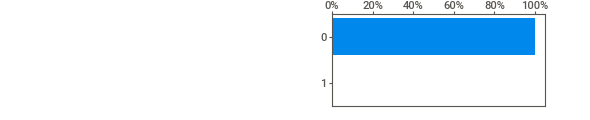
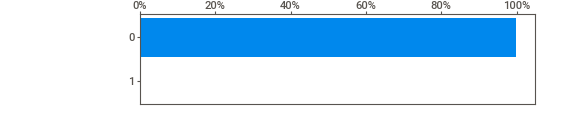
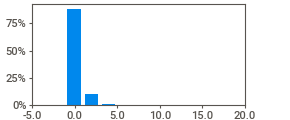
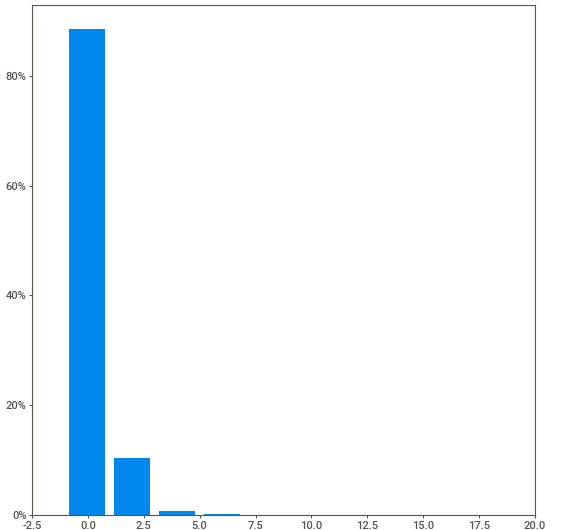
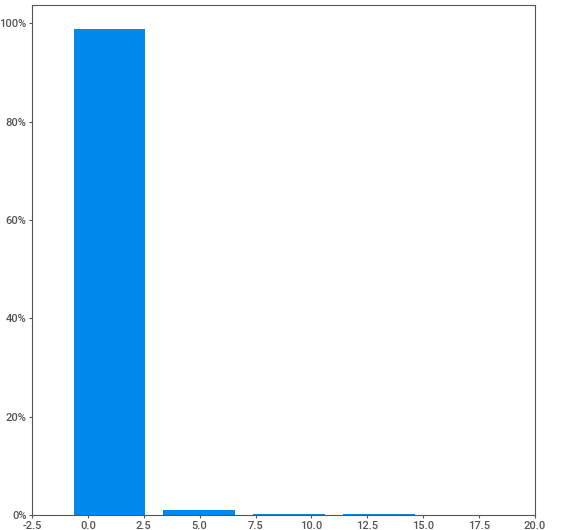
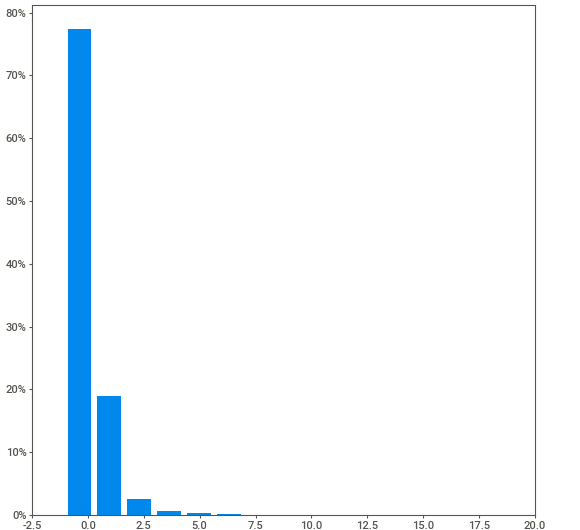
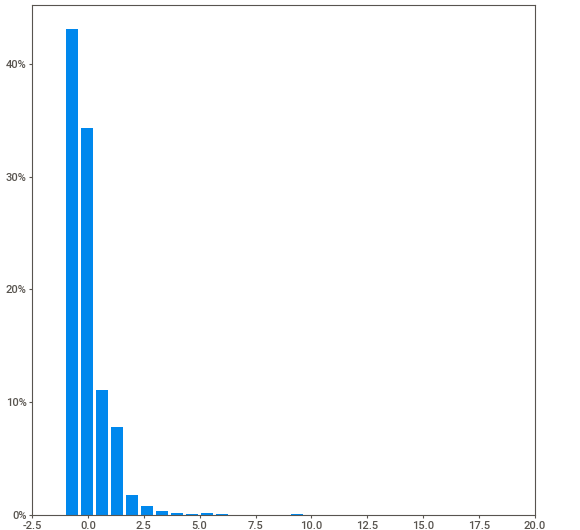
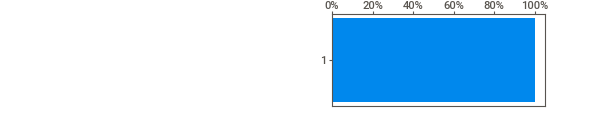
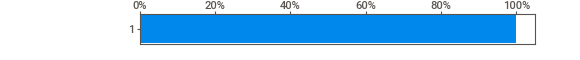
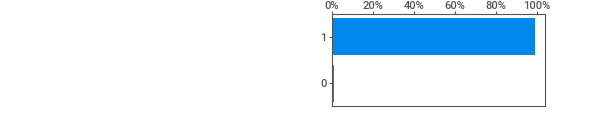
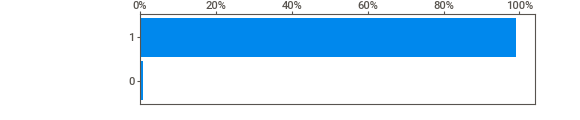
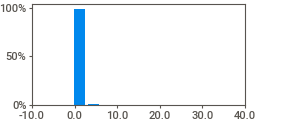
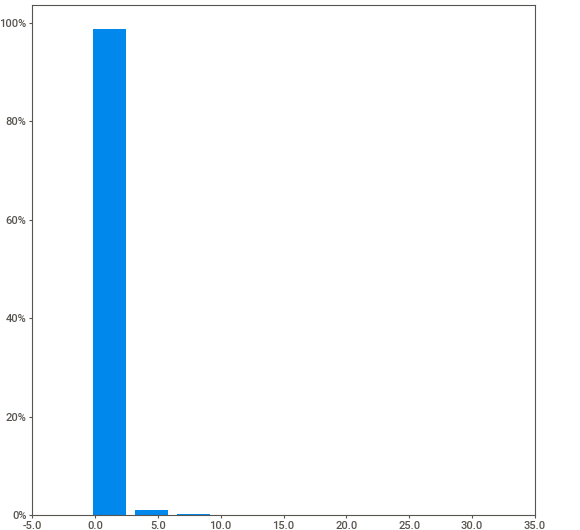
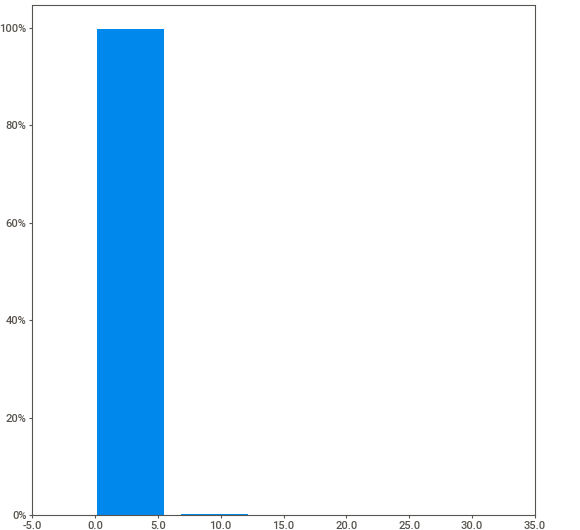
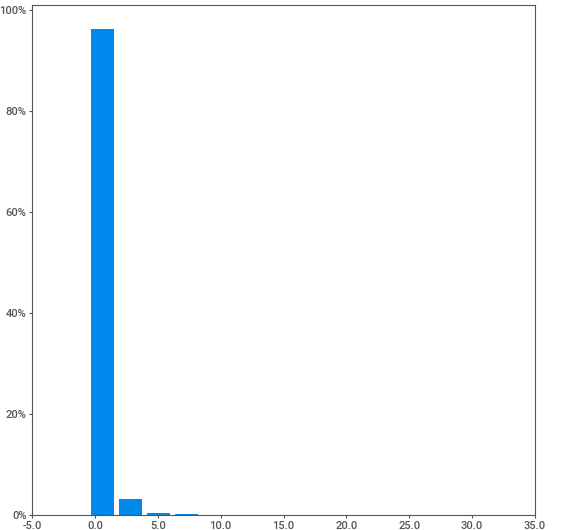
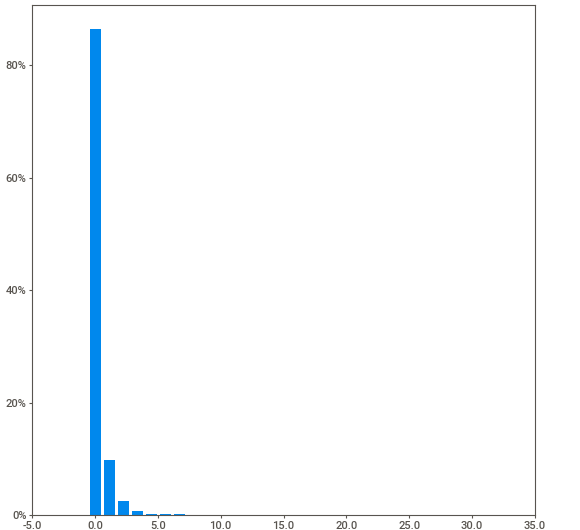
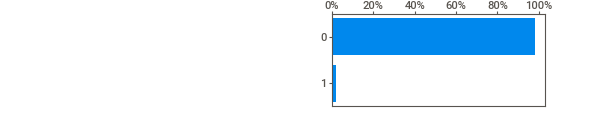
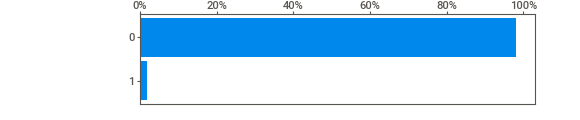
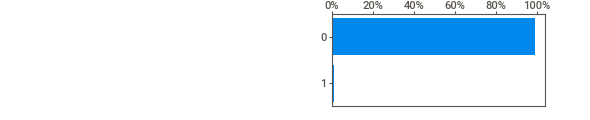
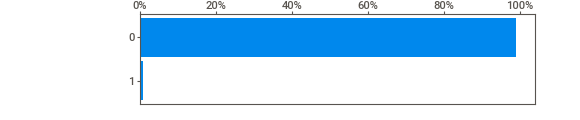
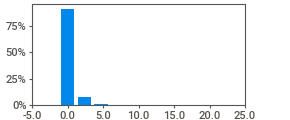
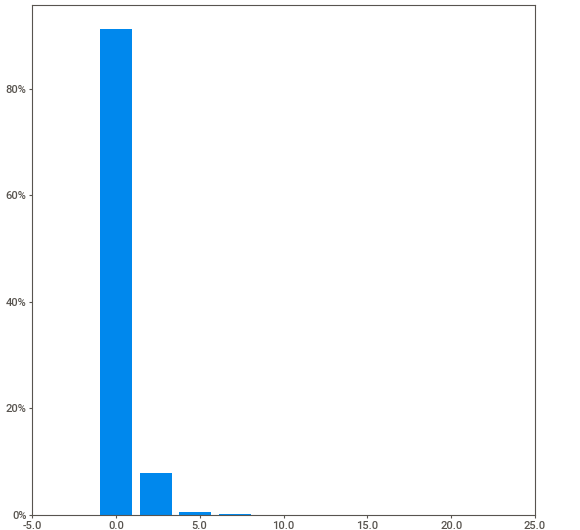
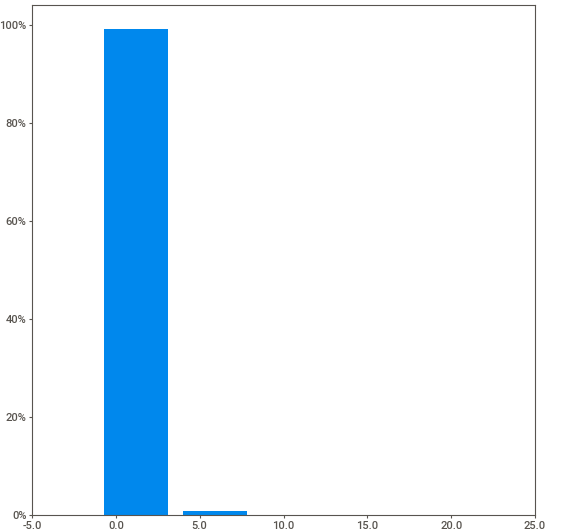
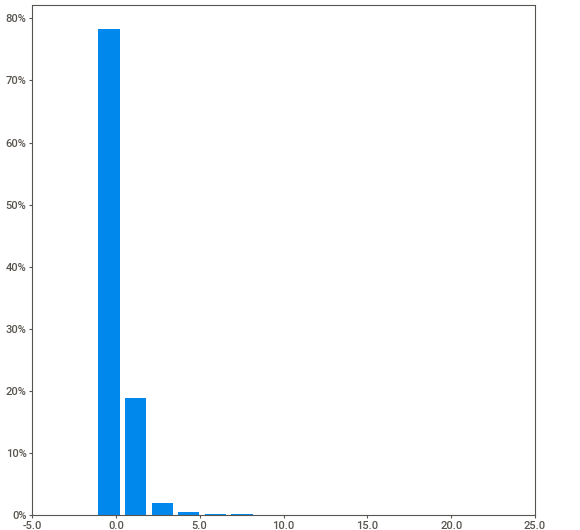
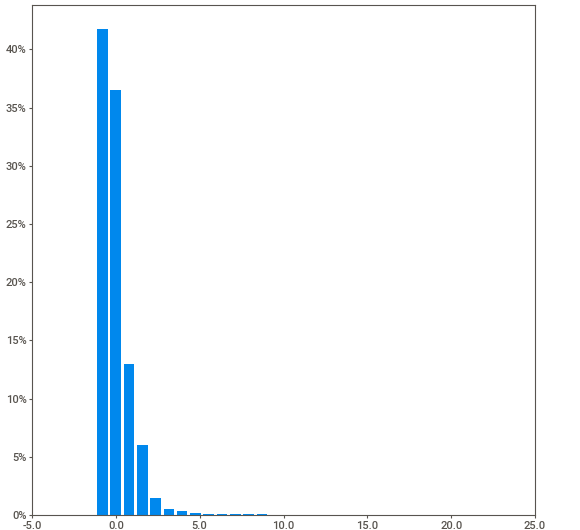
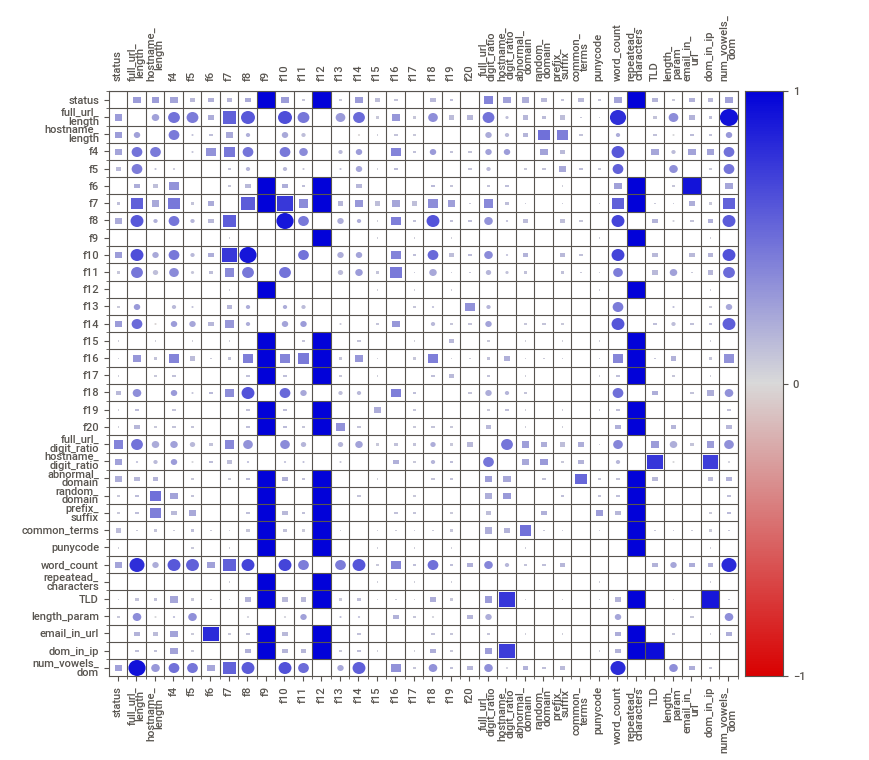
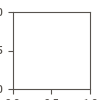

Report ./data/reporte.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [56]:
import pandas as pd
import sweetviz as sv

df = pd.read_csv('./data/dataset_preprocesado.csv')

reporte = sv.analyze(df)

reporte.show_notebook()

reporte.show_html('./data/reporte.html')


Selección de características

División de datasets

In [57]:

df = pd.read_csv('./data/dataset_preprocesado.csv')

X = df.drop('status', axis=1)
y = df['status']

X_entrenamiento, X_temporal, y_entrenamiento, y_temporal = train_test_split(X, y, test_size=0.45, random_state=42, stratify=y)

X_validacion, X_prueba, y_validacion, y_prueba = train_test_split(X_temporal, y_temporal, test_size=(0.30/0.45), random_state=42, stratify=y_temporal)

df_entrenamiento = pd.concat([X_entrenamiento, y_entrenamiento], axis=1)
df_validacion = pd.concat([X_validacion, y_validacion], axis=1)
df_prueba = pd.concat([X_prueba, y_prueba], axis=1)

df_entrenamiento.to_csv('./data/entrenamiento.csv', index=False)
df_validacion.to_csv('./data/validacion.csv', index=False)
df_prueba.to_csv('./data/prueba.csv', index=False)


# Entrenamiento de modelos

# 1. Decision Tree

In [58]:


df_train = pd.read_csv('./data/entrenamiento.csv')

X_train = df_train.drop('status', axis=1)
y_train = df_train['status']

model = DecisionTreeClassifier()

model.fit(X_train, y_train)

DecisionTreeClassifier()

Predicciones del Decision Tree

In [59]:
df_test = pd.read_csv('./data/prueba.csv')

X_test = df_test.drop('status', axis=1)
y_test = df_test['status']

y_pred_test = model.predict(X_test)

print('Precisión en el conjunto de prueba:', precision_score(y_test, y_pred_test))

Precisión en el conjunto de prueba: 0.824014125956445


Métricas

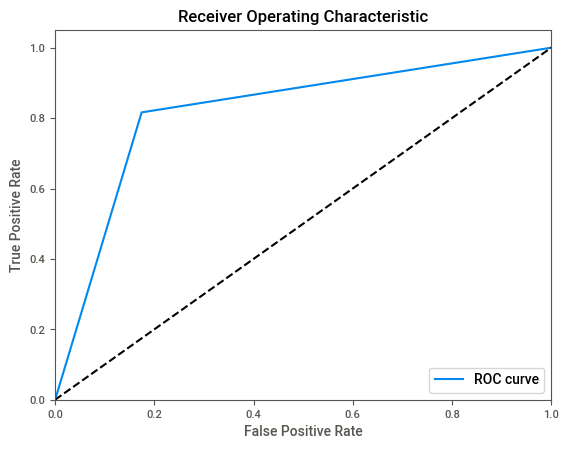

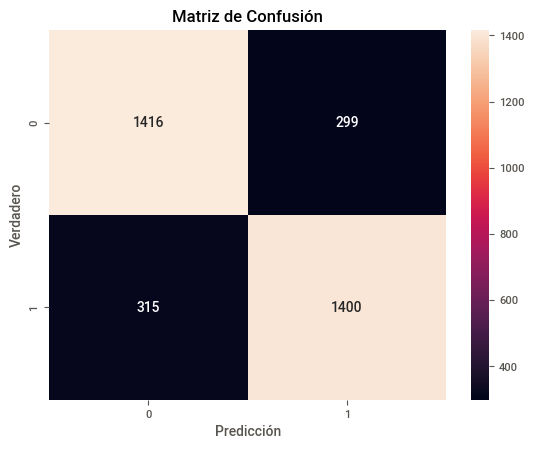

Matriz de Confusión:
[[1416  299]
 [ 315 1400]]
Precisión: 0.824014125956445
Recall: 0.8163265306122449
Área bajo la curva: 0.8209912536443149


In [63]:
cm = confusion_matrix(y_test, y_pred_test)

precision = precision_score(y_test, y_pred_test)

recall = recall_score(y_test, y_pred_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

auc_score = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

fig, ax = plt.subplots()

class_labels = np.unique(y_test)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)

ax.set_title('Matriz de Confusión')
ax.set_xlabel('Predicción')
ax.set_ylabel('Verdadero')

plt.show()

print(f'Matriz de Confusión:\n{cm}')
print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f"Área bajo la curva: {auc_score}")

### **Discusión de los resultados**

Los resultados obtenidos en la detección de phishing dentro de nuestro conjunto de datos de correos electrónicos han sido bastante positivos. La matriz de confusión revela que nuestro modelo pudo identificar correctamente el phishing en los correos electrónicos con una precisión del 82.4%. Esto significa que, en el 82.4% de las veces, nuestro modelo acertó al predecir que un correo electrónico contenía phishing. Además, nuestro modelo demostró una alta sensibilidad, con un recall del 81.6%. Esto indica que pudo identificar correctamente el 81.6% de los correos electrónicos que realmente contenían phishing. Finalmente, el valor del Área Bajo la Curva (AUC) de 0.82 refuerza la capacidad del modelo para distinguir correctamente entre correos electrónicos con y sin phishing.

# 2. Random Forest

In [61]:

df_entrenamiento = pd.read_csv('./data/entrenamiento.csv')
df_validacion = pd.read_csv('./data/validacion.csv')
df_prueba = pd.read_csv('./data/prueba.csv')

X_entrenamiento = df_entrenamiento.drop('status', axis=1)
y_entrenamiento = df_entrenamiento['status']

X_validacion = df_validacion.drop('status', axis=1)
y_validacion = df_validacion['status']

X_prueba = df_prueba.drop('status', axis=1)
y_prueba = df_prueba['status']

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_entrenamiento, y_entrenamiento)

predicciones_validacion = rf_model.predict(X_validacion)

accuracy_validacion = accuracy_score(y_validacion, predicciones_validacion)
print(f'Accuracy en el conjunto de validación: {accuracy_validacion:.2f}')

print('\nInforme de clasificación en el conjunto de validación:\n', classification_report(y_validacion, predicciones_validacion))

predicciones_prueba = rf_model.predict(X_prueba)

accuracy_prueba = accuracy_score(y_prueba, predicciones_prueba)
print(f'\nAccuracy en el conjunto de prueba: {accuracy_prueba:.2f}')

print('\nInforme de clasificación en el conjunto de prueba:\n', classification_report(y_prueba, predicciones_prueba))


Accuracy en el conjunto de validación: 0.87

Informe de clasificación en el conjunto de validación:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       857
           1       0.86      0.88      0.87       857

    accuracy                           0.87      1714
   macro avg       0.87      0.87      0.87      1714
weighted avg       0.87      0.87      0.87      1714


Accuracy en el conjunto de prueba: 0.87

Informe de clasificación en el conjunto de prueba:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1715
           1       0.86      0.88      0.87      1715

    accuracy                           0.87      3430
   macro avg       0.87      0.87      0.87      3430
weighted avg       0.87      0.87      0.87      3430



### Metricas

Matriz de Confusión:
[[1479  236]
 [ 209 1506]]
Precision en el conjunto de prueba: 0.86
Recall en el conjunto de prueba: 0.88


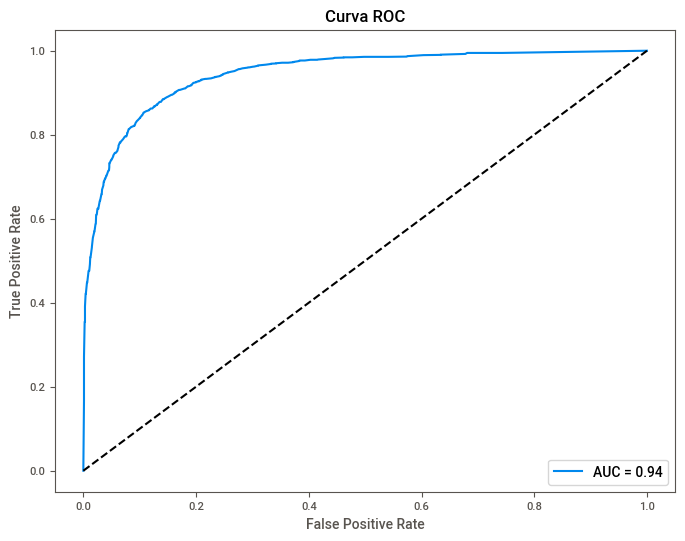

Área bajo la curva (AUC): 0.94


In [62]:
matriz_confusion = confusion_matrix(y_prueba, predicciones_prueba)

precision = precision_score(y_prueba, predicciones_prueba)
recall = recall_score(y_prueba, predicciones_prueba)

print(f'Matriz de Confusión:\n{matriz_confusion}')
print(f'Precision en el conjunto de prueba: {precision:.2f}')
print(f'Recall en el conjunto de prueba: {recall:.2f}')

probabilidades = rf_model.predict_proba(X_prueba)[:, 1]
fpr, tpr, umbrales = roc_curve(y_prueba, probabilidades)
area_bajo_curva = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {area_bajo_curva:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

print(f'Área bajo la curva (AUC): {area_bajo_curva:.2f}')


### **Discusión de los resultados**

Los resultados obtenidos en la detección de phishing para nuestro conjunto de datos de correos electrónicos han sido muy satisfactorios. La precisión y el recall en el conjunto de validación y de prueba fueron altos, obteniendo resultados del 86% al 88% de precisión. Lo anterior indica que nuestro modelo fue y es capaz de identificar correctamente el phishing en los correos electrónicos con una alta tasa de éxito. Por otro lado, la matriz de confusión muestra que nuestro modelo tuvo un equilibrio bueno entre la identificación correcta de los correos electrónicos de phishing (1506 verdaderos positivos) y la minimización de las falsas alarmas (236 falsos positivos). La precisión en el conjunto de prueba fue de 0.86 y el recall fue de 0.88, lo que indica que nuestro modelo fue capaz de identificar correctamente el 88% de los correos electrónicos que realmente contenían phishing. Finalmente, el es importante mencionar que el valor del Área Bajo la Curva (AUC) de 0.94 es particularmente bueno, diciendo así que nuestro modelo tiene una excelente capacidad para distinguir entre correos electrónicos con y sin phishing. 

Es importante destacar que, para la detección de phishing, resulta especialmente útil emplear un modelo basado en Árboles de Decisión. Este tipo de modelos demuestra un rendimiento excepcional al detectar comportamientos anómalos o patrones de texto que podrían interpretarse como fraudulentos.

3. ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?

- El impacto de clasificar incorrectamente un modelo es que los usuarios perderían confianza en la empresa o entidad que tienen las páginas levantadas. Asimismo, se dañaría por completo la reputación de los sitios web que las entidades tengan levantadas.

4. ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?

- Uno de los impactos más grandes al momento de clasificar los sitios de pishing como legítimo es que las personas podrían tener una trágica pérdida de datos al momento de ingresar al sitio web. Por otro lado, las personas empezarían a perder confianza en el/los sitios que están ingresando. Finalmente, habría una propagación de malware desde la página hacia los usuarios.

5. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?

- La longitud de los links, la cantidad de links, la cantidad de caracteres especiales, etc. Las métricas que utilizaría para poder comparar modelos similares de clasificación de phishing serían la precisión y el recall.

6. ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?

- El modelo que mejores resultados presentó fue el de Random Forest, dado que éste presentó mejores resultados con respecto a la precisión y al área bajo la curva.

7. Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué se podría hacer para reducir la cantidad de falsas alarmas?

- 